# Compare multi fitted atmospheric parameters with MERRA2

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : April 25th 2023
- last update : April 25th 2023

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline
import pickle
import seaborn as sns
import copy
from collections import OrderedDict

In [2]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [3]:
import time
from datetime import datetime,date
from astropy.time import Time
import dateutil.parser
import pytz

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

# Config

## MERRA2

In [5]:
path_merra2="data/merra2"
files_merra2=["MERRA2_2022_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv","MERRA2_2023_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv"]

In [6]:
all_merra2 = []
for file in files_merra2:
    merra2 = pd.read_csv(os.path.join(path_merra2,file))
    all_merra2.append(merra2)

In [7]:
merra2 = pd.concat(all_merra2,axis=0)

In [8]:
all_merra2_datetime = [ Time(str_time).to_datetime() for str_time in merra2['time'] ]
pwv_merra2 = merra2['TQV']
oz_merra2 = merra2['TO3']

Text(0.5, 1.0, 'precipitable water vapor in MERRA2 in 2022 and 2023')

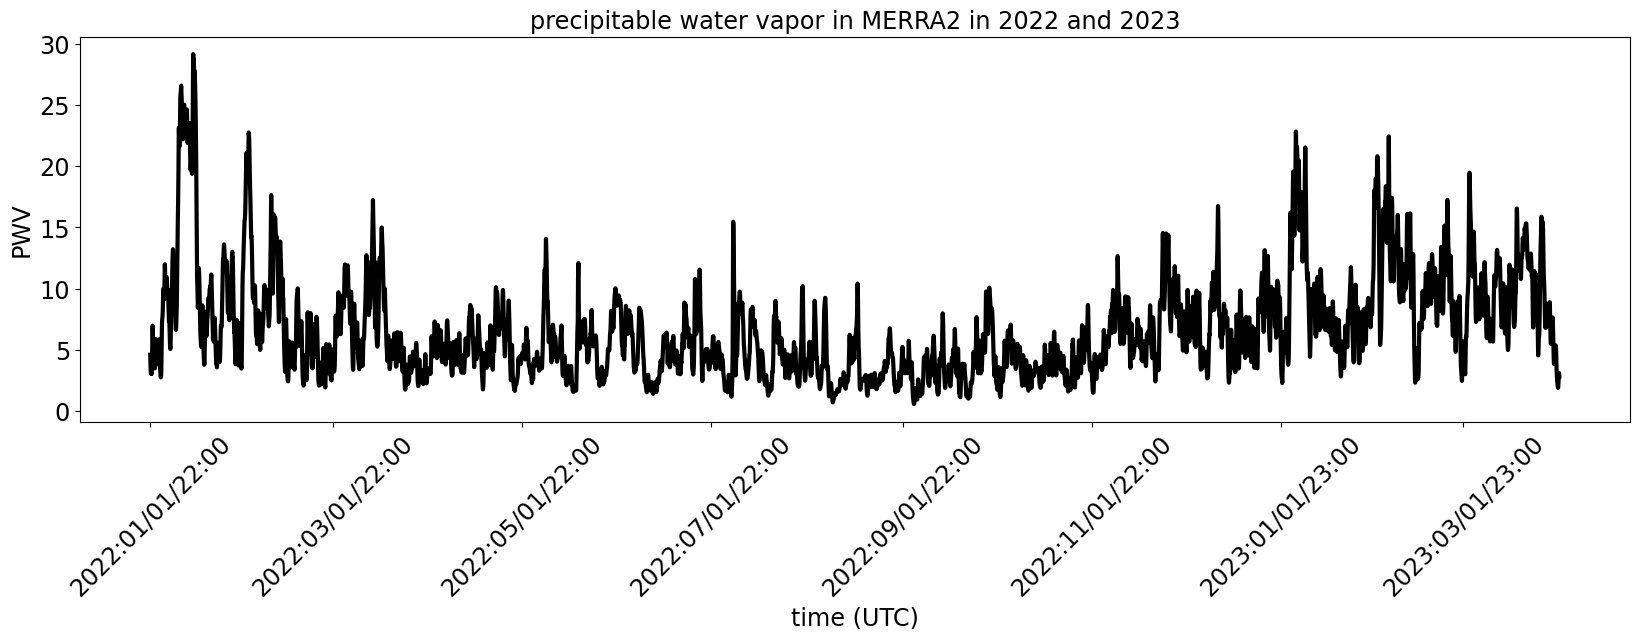

In [9]:
fig=plt.figure(figsize=(20,5))
    
ax=fig.add_subplot(111)
#myFmt = mdates.DateFormatter('%H:%M')
myFmt = mdates.DateFormatter('%Y:%D:%H')
ax.xaxis.set_major_formatter(myFmt)

ax.plot(all_merra2_datetime,pwv_merra2 ,'-',color='k',lw=3)
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel("time (UTC)")
ax.set_ylabel("PWV")
ax.set_title('precipitable water vapor in MERRA2 in 2022 and 2023')

In [10]:
all_merra2_datetime = [ Time(str_time).to_datetime() for str_time in merra2['time'] ]
oz_merra2 = merra2['TO3']

(0.0, 600.0)

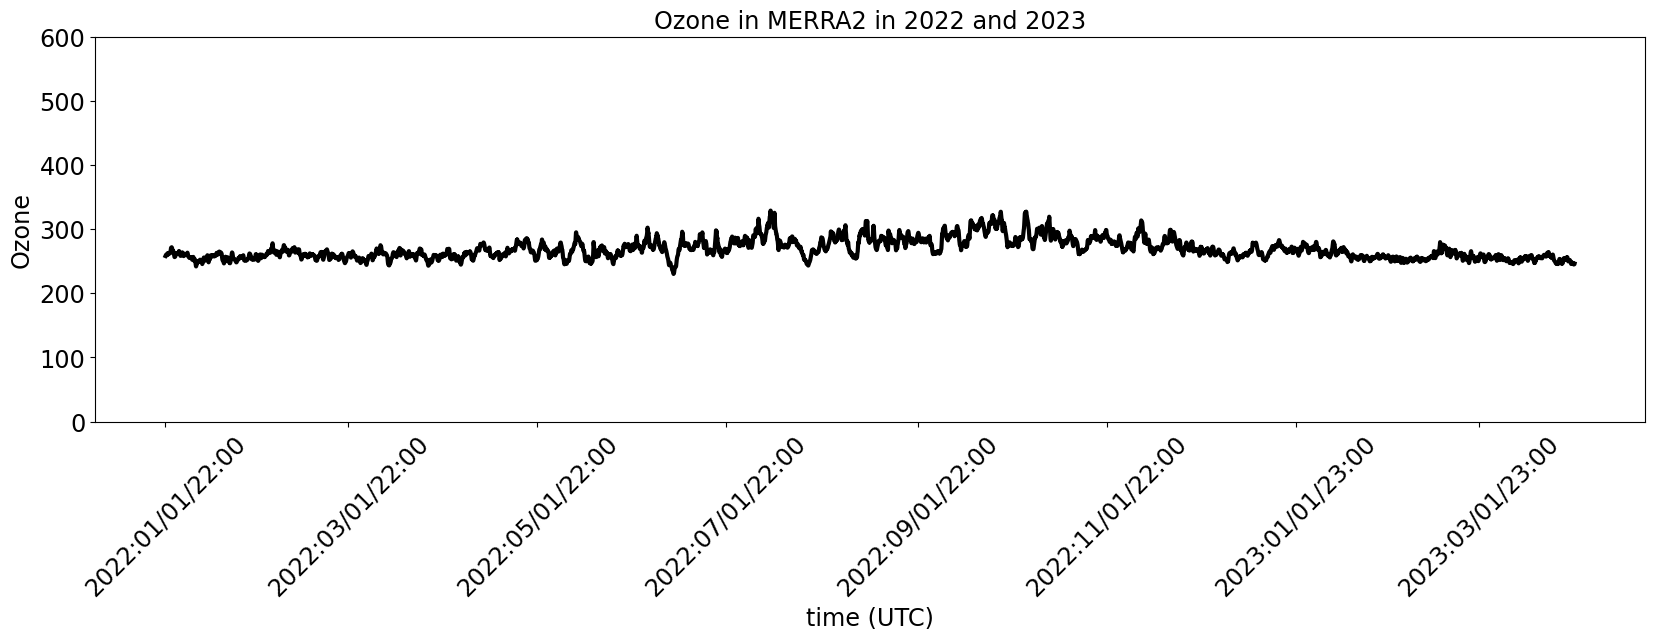

In [11]:
fig=plt.figure(figsize=(20,5))
    
ax=fig.add_subplot(111)
#myFmt = mdates.DateFormatter('%H:%M')
myFmt = mdates.DateFormatter('%Y:%D:%H')
ax.xaxis.set_major_formatter(myFmt)

ax.plot(all_merra2_datetime,oz_merra2 ,'-',color='k',lw=3)
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel("time (UTC)")
ax.set_ylabel("Ozone")
ax.set_title('Ozone in MERRA2 in 2022 and 2023')
ax.set_ylim(0,600)

## Data

In [12]:
DATE="2022 - 2023"
#DATE="2022/03/17 and 2022/06 (29,30)"

In [13]:
FLAG_SELECT_POLAR = True
FLAG_SELECT_REMOVE_BIGSIGMA = True

In [14]:
if FLAG_SELECT_POLAR:
    tag_stars = "HD185975_star"
else:
    tag_stars = "all_stars"

In [15]:
path_out = "dataout/fitparamatm"

In [17]:
filenames = [
"multifitcovparamatm-2022-11-23-empty~holo4_003-psf2dffm-polar.csv",
"multifitcovparamatm-2022-12-08-empty~holo4_003-psf2dffm-polar.csv",
"multifitcovparamatm-2022-12-09-empty~holo4_003-psf2dffm-polar.csv",
"multifitcovparamatm-2023-01-17-empty~holo4_003-psf2dffm-polar.csv",
"multifitcovparamatm-2023-01-18-empty~holo4_003-psf2dffm-polar.csv",
"multifitcovparamatm-2023-01-19-empty~holo4_003-psf2dffm-polar.csv",
"multifitcovparamatm-2023-02-14-empty~holo4_003-psf2dffm-polar.csv",
"multifitcovparamatm-2023-02-15-empty~holo4_003-psf2dffm-polar.csv",
"multifitcovparamatm-2023-02-16-empty~holo4_003-psf2dffm-polar.csv",
"multifitcovparamatm-2023-02-28-empty~holo4_003-psf2dffm-polar.csv",
"multifitcovparamatm-2023-03-01-empty~holo4_003-psf2dffm-polar.csv",
"multifitcovparamatm-2023-03-02-empty~holo4_003-psf2dffm-polar.csv",
"multifitcovparamatm-2023-03-15-empty~holo4_003-psf2dffm-polar.csv",
"multifitcovparamatm-2023-03-16-empty~holo4_003-psf2dffm-polar.csv",
]

In [18]:
NDAYS = len(filenames)
tags = [
    "2022/11/23","2022/12/08","2022/12/09",
    "2023/01/17","2023/01/18","2023/01/19",
    "2023/02/14","2023/02/15","2023/02/16","2023/02/28",
    "2023/03/01","2023/03/02","2023/03/15","2023/03/16"
]

In [19]:
all_df = []
for filename in filenames:
    df = pd.read_csv(os.path.join(path_out,filename), index_col=0)
    df=df.dropna(axis=0)
    
    if FLAG_SELECT_POLAR:
        df = df[df["spec_target_label"]=='HD185975']
        
    if FLAG_SELECT_REMOVE_BIGSIGMA:
        df =df[df["pwv_sig"]<1]
    all_df.append(df)

In [20]:
df

index       exposure                   spec_date_obs spec_target_label   
0       0  2023031600465  2023-03-17T06:20:56.082001145Z          HD185975  \
1       1  2023031600466  2023-03-17T06:21:39.074005228Z          HD185975   
2       8  2023031600505  2023-03-17T06:52:06.172502735Z          HD185975   
3       9  2023031600506  2023-03-17T06:52:49.175495727Z          HD185975   
4      16  2023031600544  2023-03-17T07:26:52.619493301Z          HD185975   
5      17  2023031600545  2023-03-17T07:27:35.585004713Z          HD185975   
6      26  2023031600589  2023-03-17T07:59:53.341001019Z          HD185975   
7      27  2023031600590  2023-03-17T08:00:36.347990813Z          HD185975   
8      37  2023031600645  2023-03-17T08:43:51.125005011Z          HD185975   
9      38  2023031600646  2023-03-17T08:44:34.193006376Z          HD185975   
10     45  2023031600681  2023-03-17T09:17:21.585506918Z          HD185975   
11     46  2023031600682  2023-03-17T09:18:04.497498865Z          HD185975   

   spec_filter_label  spec_airmass  spec_pressure  spec_temperature   
0              empty      2.034006              0                 0  \
1              empty      2.033523              0                 0   
2              empty      2.013025              0                 0   
3              empty      2.012533              0                 0   
4              empty      1.989428              0                 0   
5              empty      1.988936              0                 0   
6              empty      1.967435              0                 0   
7              empty      1.966954              0                 0   
8              empty      1.939320              0                 0   
9              empty      1.938865              0                 0   
10             empty      1.919228              0                 0   
11             empty      1.918809              0                 0   

    spec_humidity  spec_hour_angle  ...   egrey_3     SNR_3     chi2_4   
0               0      -107.983587  ...  0.004077  0.090913  26.186849  \
1               0      -107.803713  ...  0.001320  0.059766   3.779965   
2               0      -100.287611  ...  0.003339  0.218959  17.977881   
3               0      -100.107582  ...  0.002705  0.003425  11.050183   
4               0       -91.696580  ...  0.004178  0.173574  87.636143   
5               0       -91.517218  ...  0.003387  0.000556  16.140642   
6               0       -83.628469  ...  0.002581  0.046287  11.629380   
7               0       -83.448648  ...  0.001948  0.014420   6.401902   
8               0       -72.914176  ...  0.003266  0.028791  15.038974   
9               0       -72.734137  ...  0.002576  0.049594  10.624450   
10              0       -64.681493  ...  0.001605  0.004579   4.447019   
11              0       -64.502596  ...  0.002151  0.062389   6.013407   

       pwv_4    grey_4    epwv_4   egrey_4     SNR_4   pwv_avg   pwv_sig  
0   6.309265  1.000386  0.451908  0.002948  0.163989  5.485352  0.496158  
1   6.596235  1.014952  0.186864  0.001206  0.031077  6.241020  0.555942  
2   6.132925  1.013341  0.374993  0.002455  0.075281  5.413093  0.475768  
3   6.487817  1.011192  0.296783  0.001933  0.088479  5.453372  0.626046  
4   5.253455  1.011087  0.765208  0.005233  0.100871  4.109853  0.628623  
5   6.265293  1.013693  0.358565  0.002344  0.048332  5.090668  0.726499  
6   6.037212  1.015865  0.302178  0.001960  0.024015  5.283627  0.600988  
7   6.257694  1.022070  0.226937  0.001473  0.025808  5.582819  0.605181  
8   5.641604  1.014928  0.337094  0.002202  0.058981  4.584843  0.619398  
9   5.764122  1.016409  0.287014  0.001873  0.059926  4.975795  0.484521  
10  5.919923  1.029023  0.188087  0.001241  0.009370  5.508866  0.494929  
11  5.783747  1.020060  0.217599  0.001415  0.002415  4.507684  0.972110  

[12 rows x 97 columns]

In [21]:
NF =len(all_df)

In [22]:
all_df[0].head()

index       exposure                   spec_date_obs spec_target_label   
0      0  2022112300238  2022-11-24T01:00:06.443008200Z          HD185975  \
1      1  2022112300239  2022-11-24T01:00:49.344002496Z          HD185975   

  spec_filter_label  spec_airmass  spec_pressure  spec_temperature   
0             empty      1.900248              0                 0  \
1             empty      1.900613              0                 0   

   spec_humidity  spec_hour_angle  ...   egrey_3     SNR_3     chi2_4 pwv_4   
0              0      -300.387001  ...  0.001263  0.023694  11.618871   9.5  \
1              0      -300.207270  ...  0.001826  0.062588  11.927775   9.5   

     grey_4    epwv_4   egrey_4     SNR_4   pwv_avg   pwv_sig  
0  0.905600  0.499205  0.002503  0.073454  8.339606  0.832815  
1  1.172988  0.450729  0.002925  0.087793  8.194208  0.933484  

[2 rows x 91 columns]

In [23]:
hls_colors = sns.color_palette("hls", NF)

## Airmass

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_43988/1147230304.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r:o" (-> color='r'). The keyword argument will take precedence.
  ax.plot(all_datetime,airmasses,'r:o',color=hls_colors[idx],lw=3)


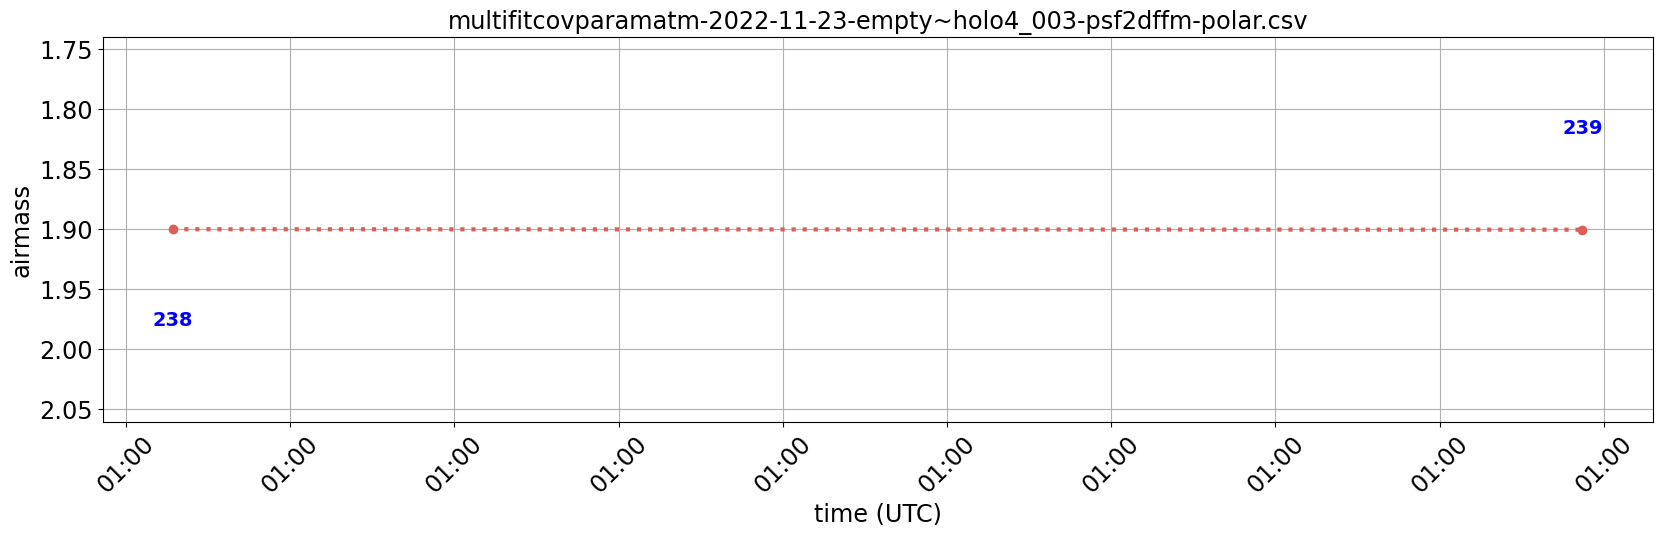

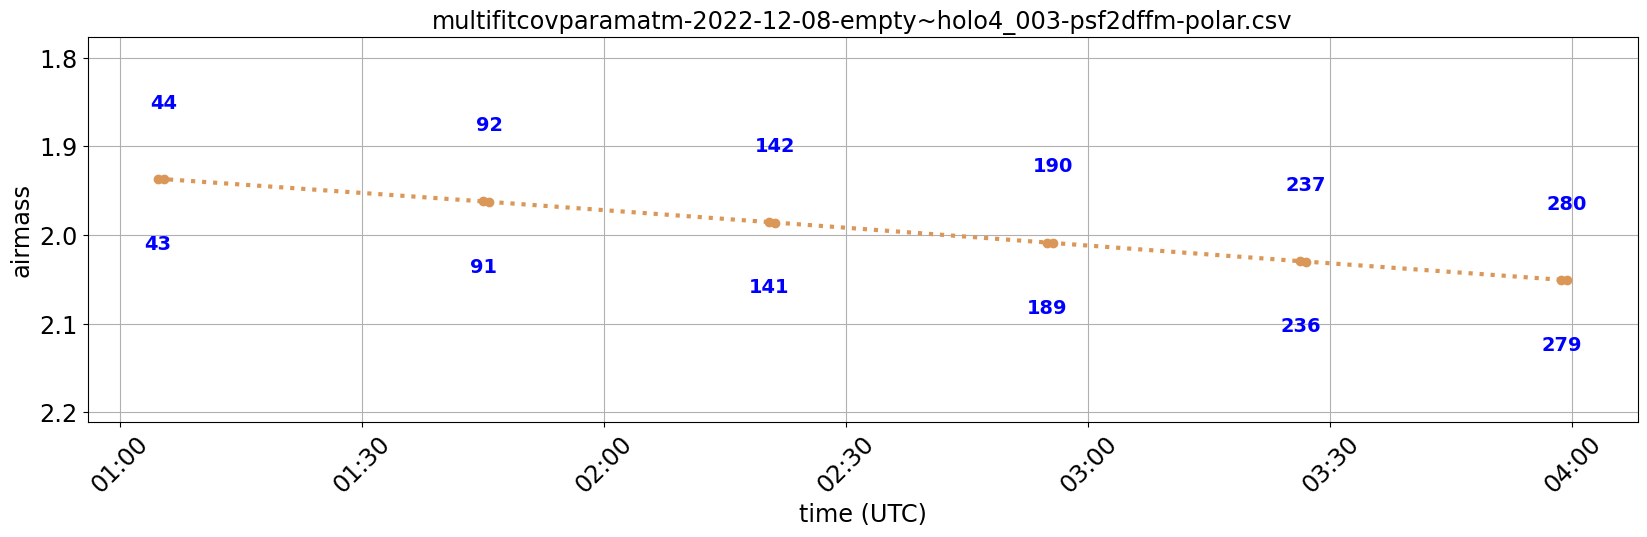

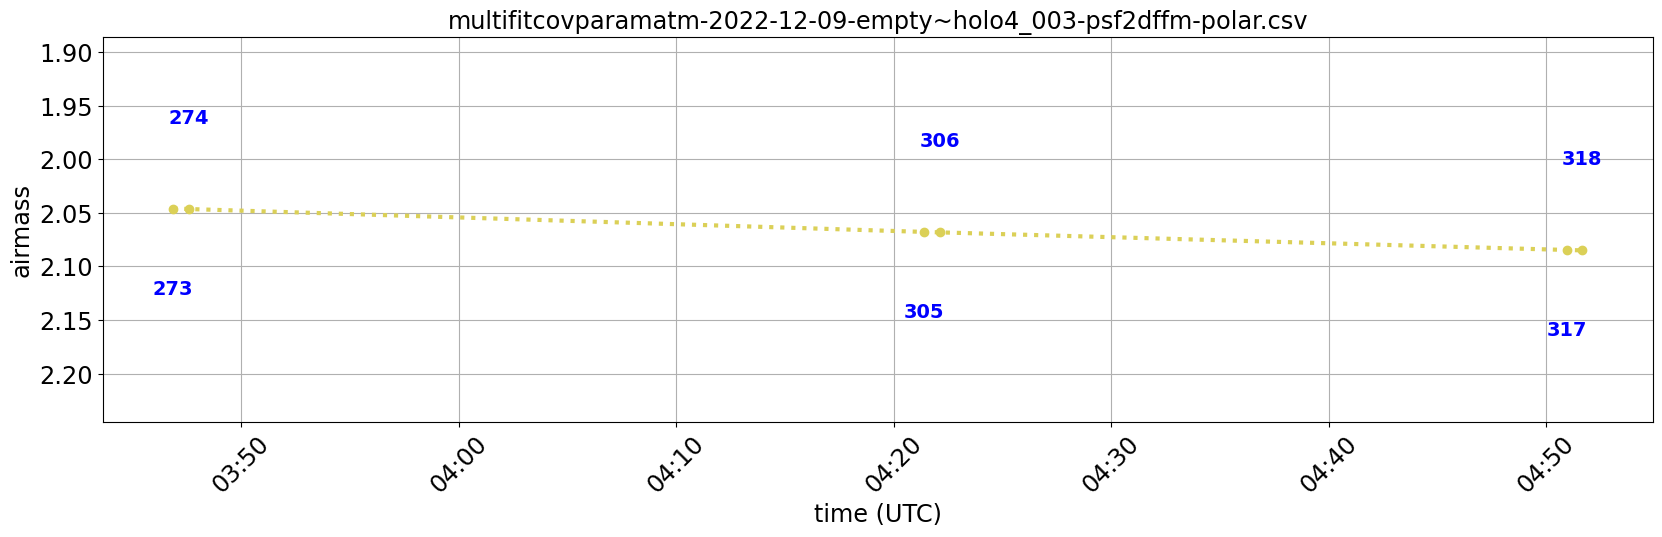

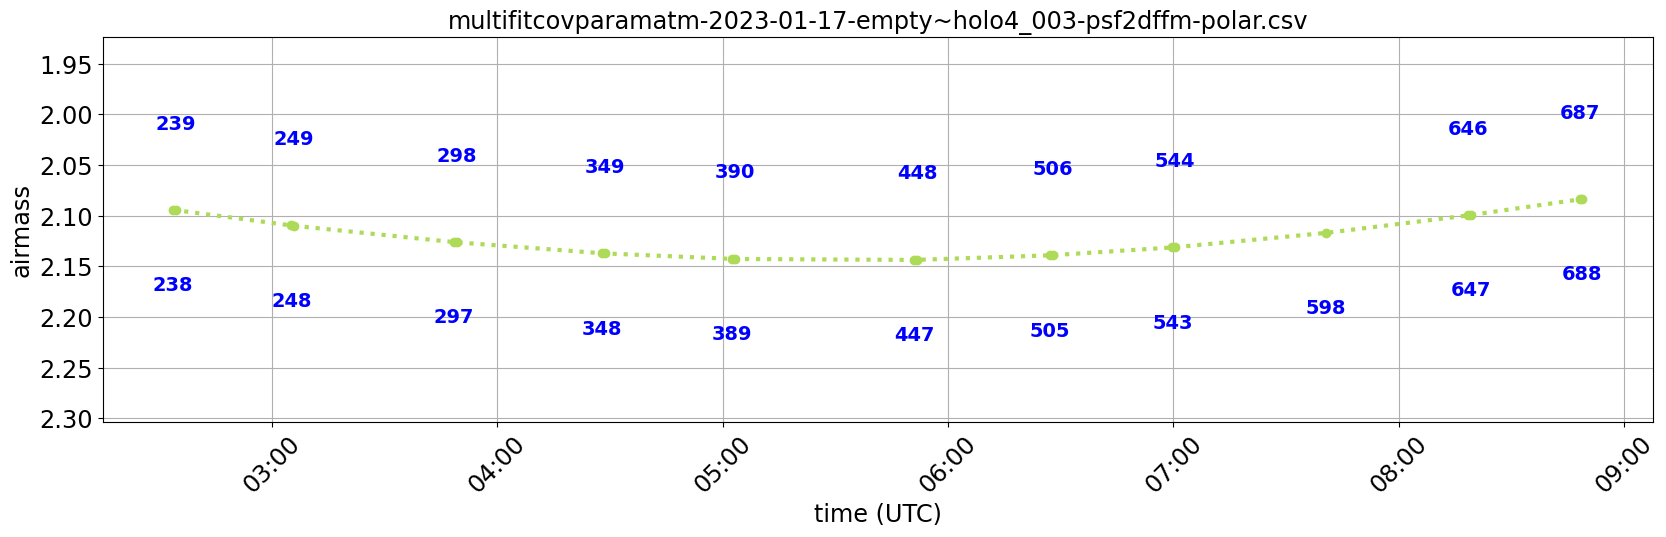

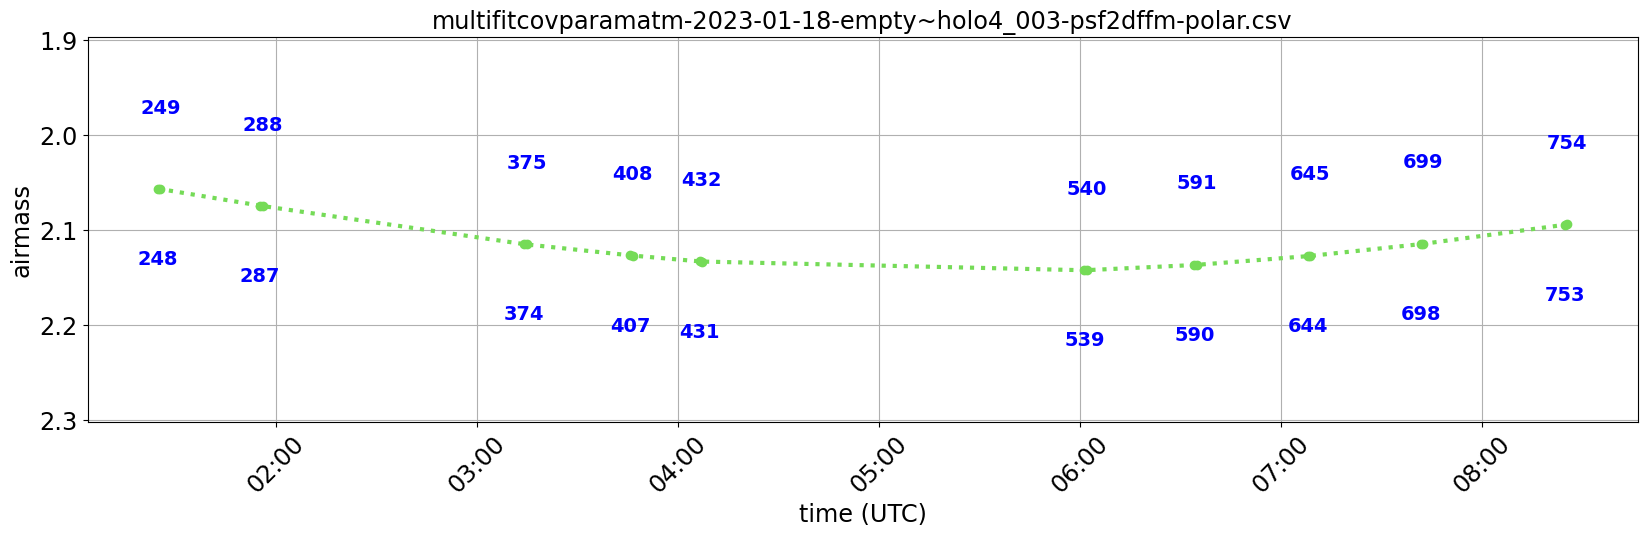

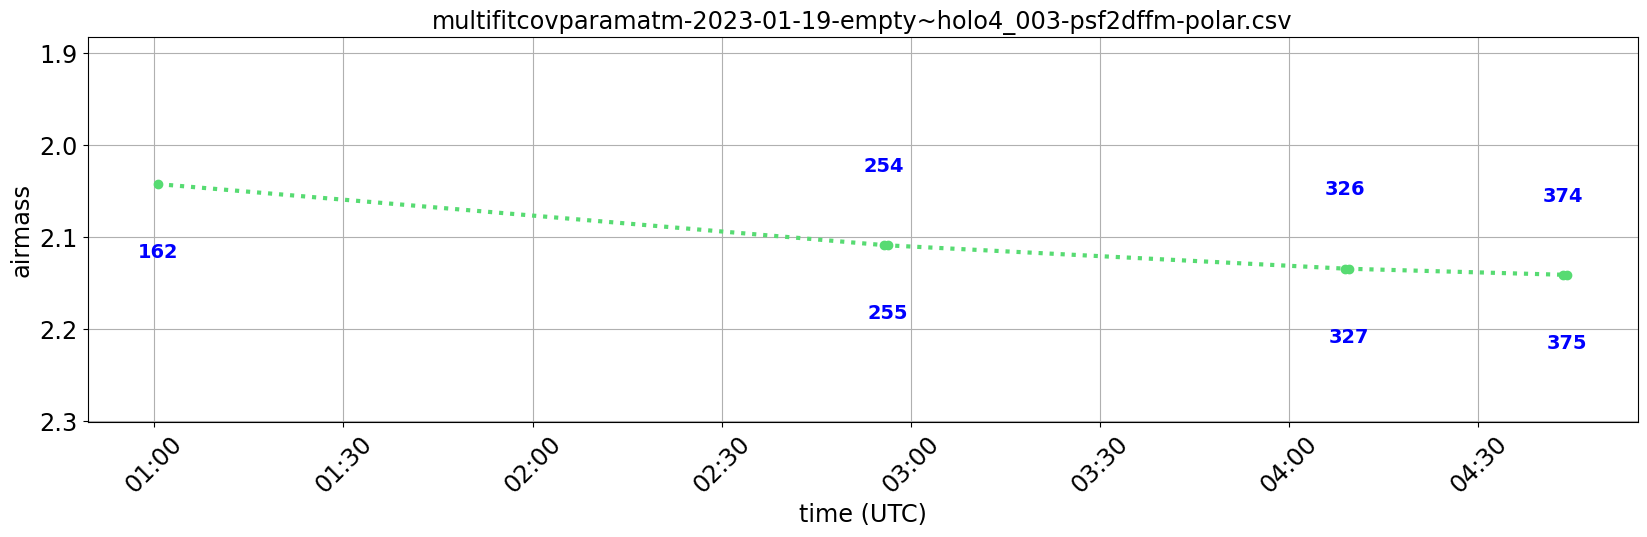

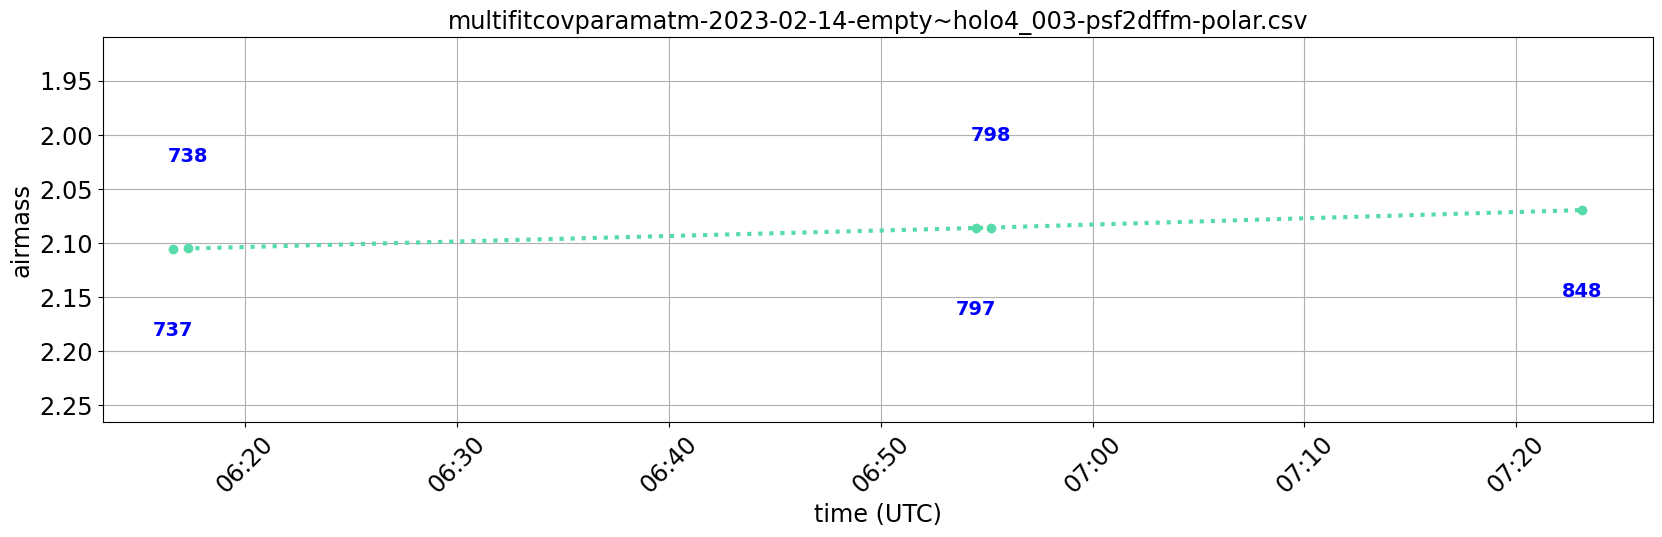

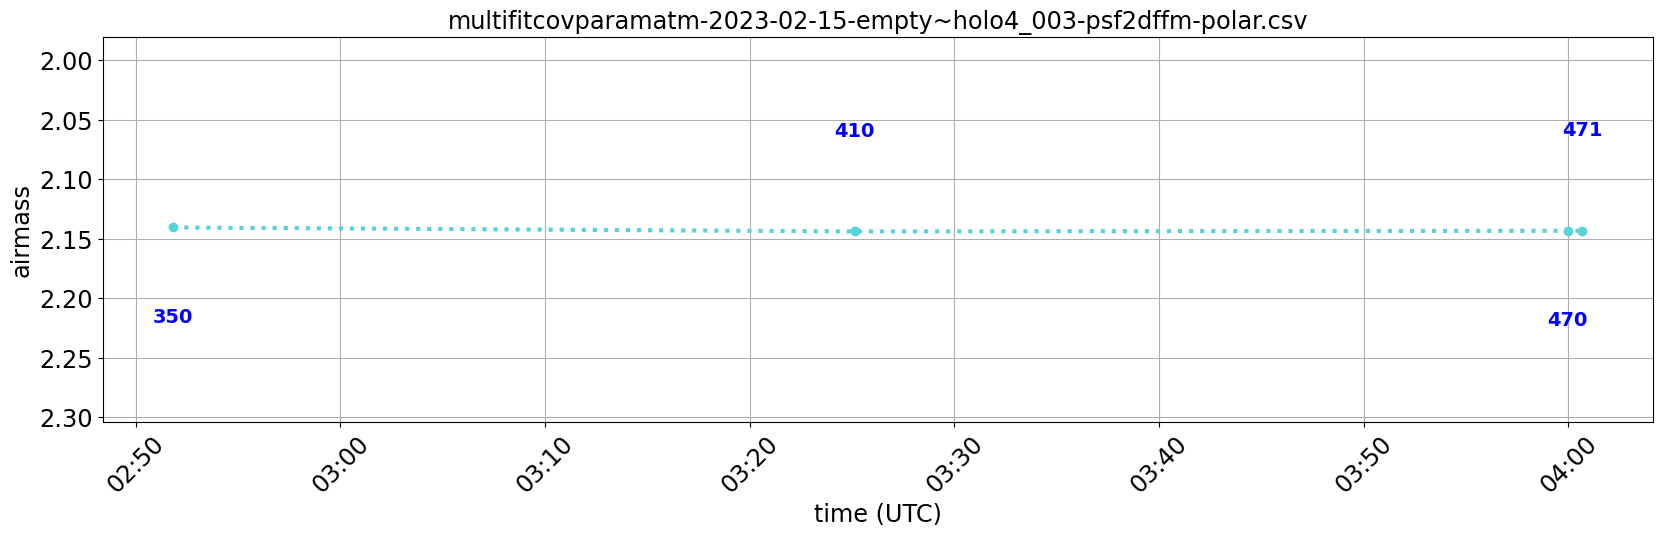

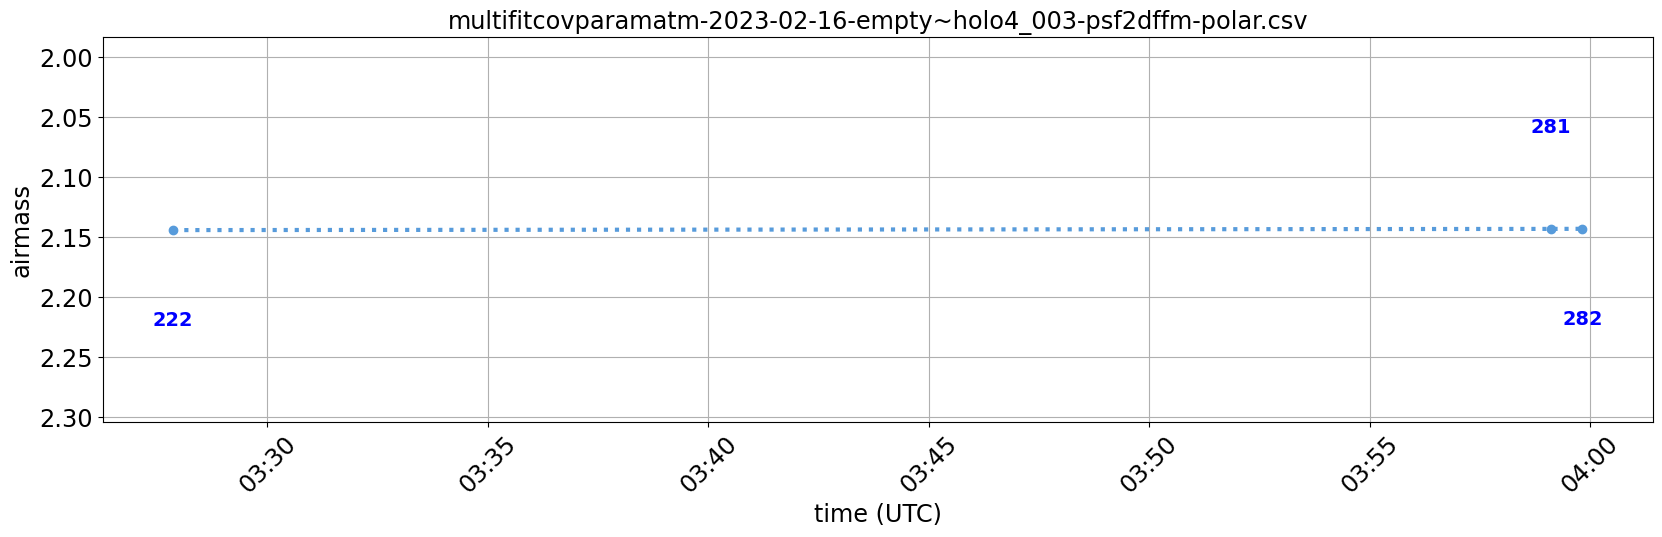

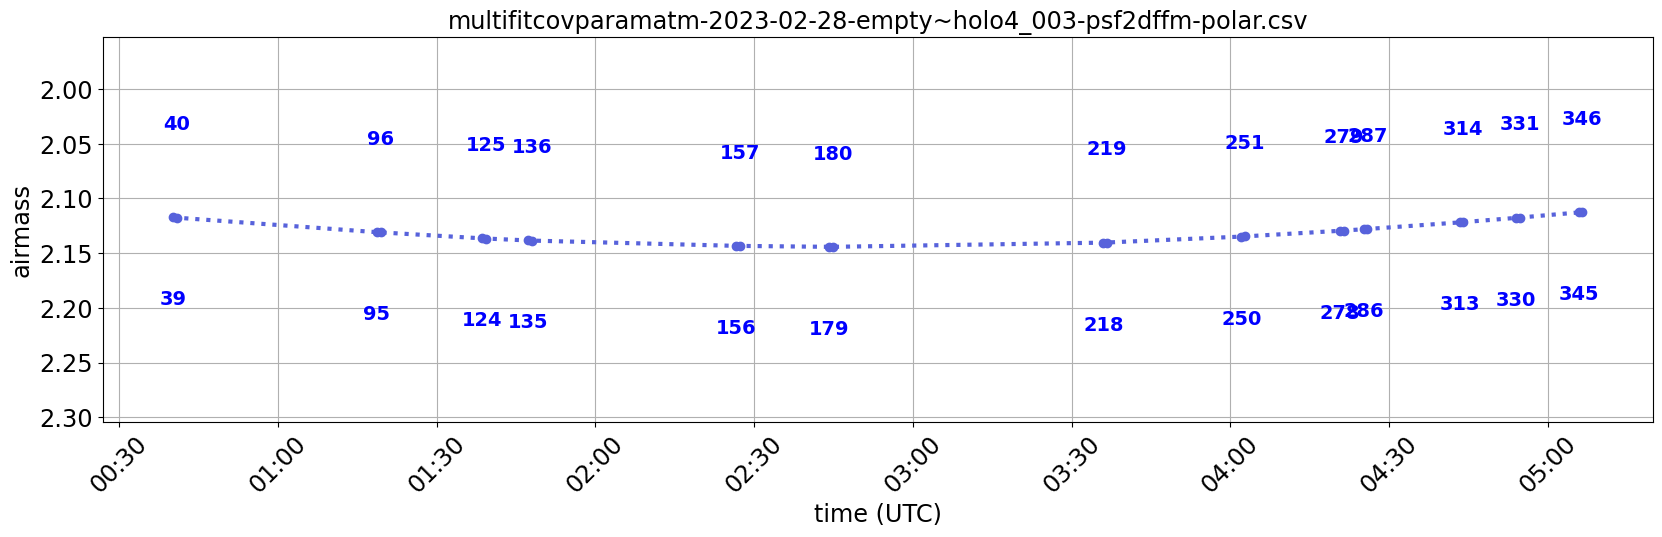

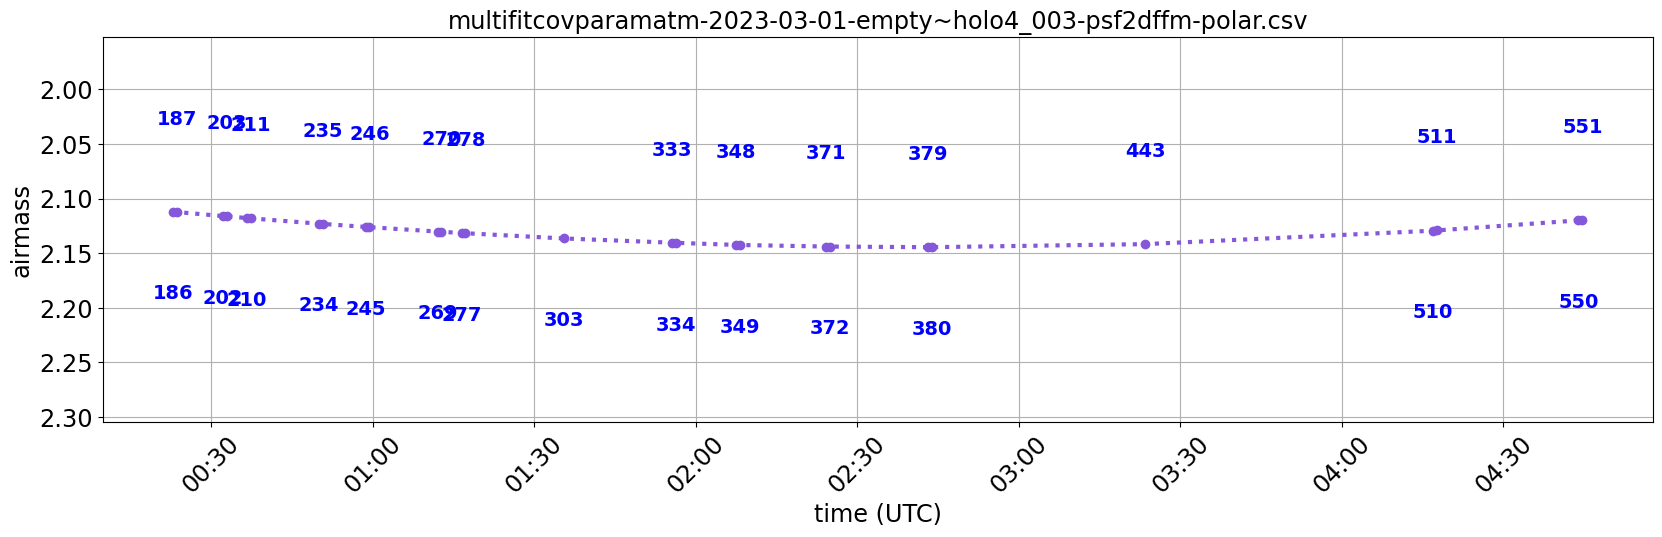

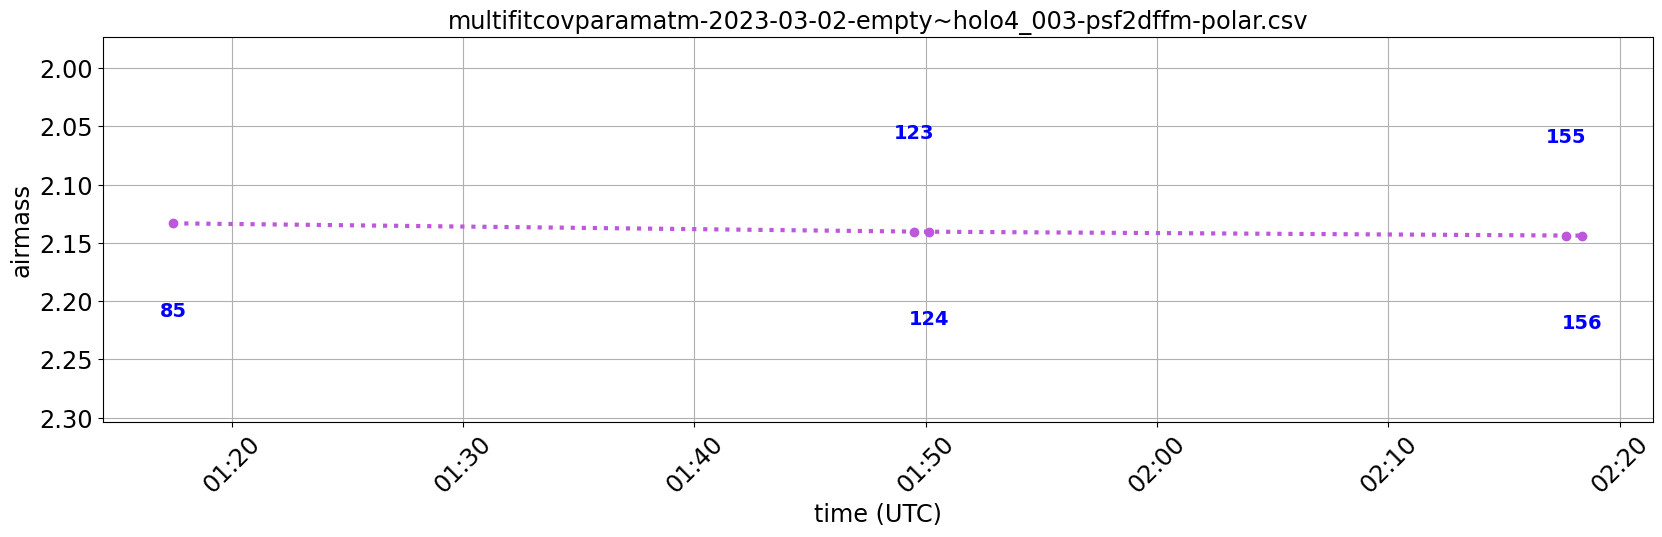

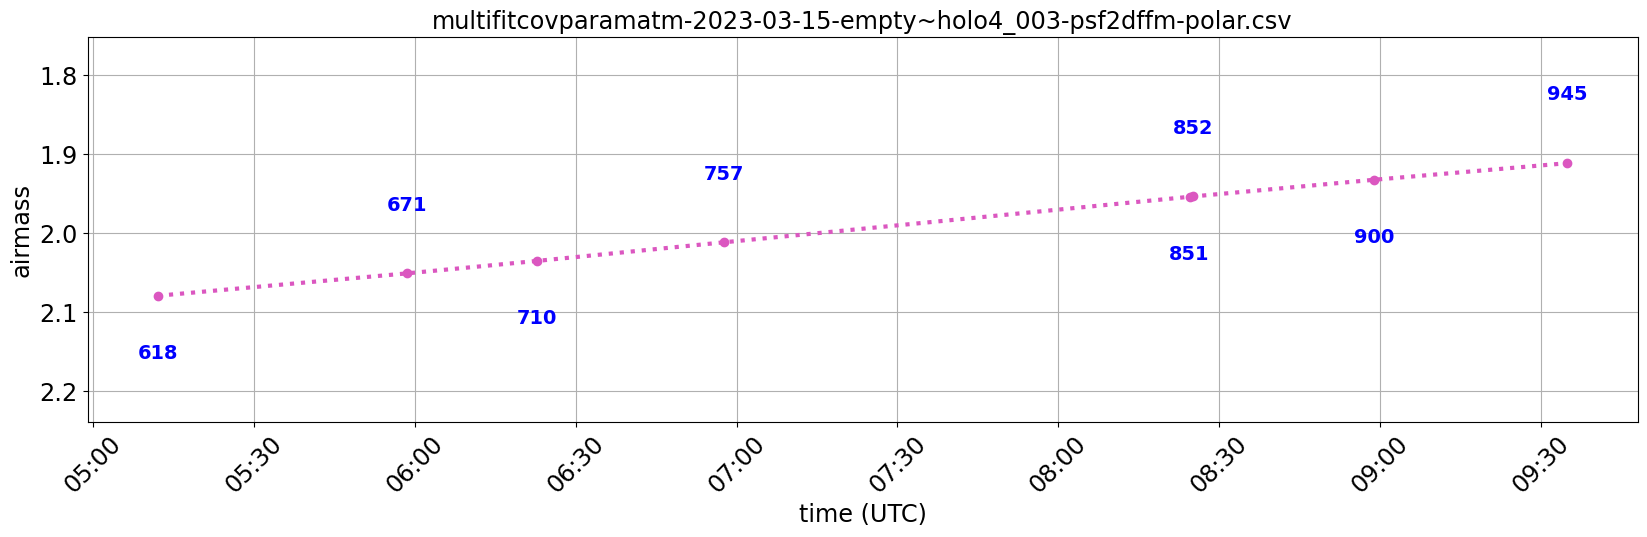

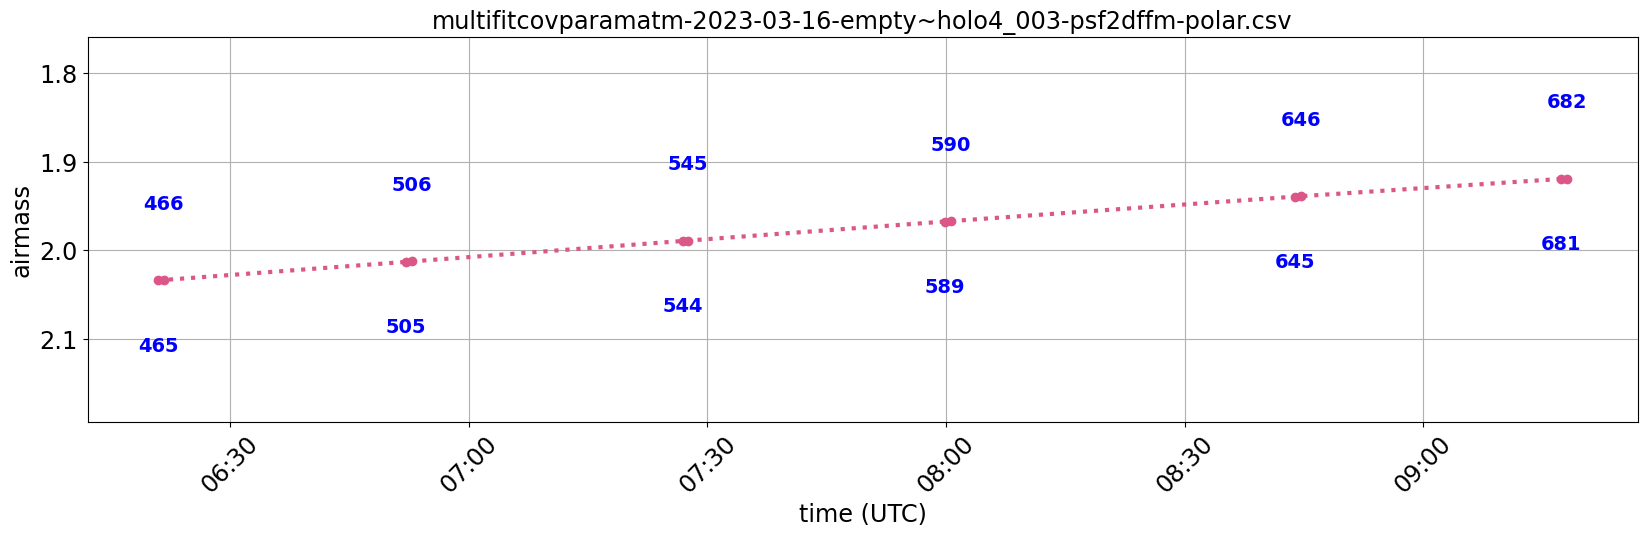

In [24]:
for idx,infos in enumerate(all_df):
    
    all_datetime = [ Time(str_time).to_datetime() for str_time in infos['spec_date_obs'] ]
    numbers = infos['number'].values
    airmasses = infos['spec_airmass'].values
    
    N= len(numbers)
    
    if N>0:
  
        # Create rectangle x coordinates
        startTime = all_datetime[0]
        endTime =  all_datetime[-1]

        # convert to matplotlib date representation
        start = mdates.date2num(startTime)
        end = mdates.date2num(endTime)
        width = end - start


        fig=plt.figure(figsize=(20,5))
    
        ax=fig.add_subplot(111)
        myFmt = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(myFmt)

    

        y_shift= 0.08

  
        ax.plot(all_datetime,airmasses,'r:o',color=hls_colors[idx],lw=3)
        ax.xaxis.set_major_formatter(myFmt)
        ax.xaxis.set_tick_params(rotation=45)
        ax.set_xlabel("time (UTC)")
        ax.set_ylabel("airmass")
        ax.set_ylim(airmasses.min()-2*y_shift,airmasses.max()+2*y_shift)
        # Plot rectangle
        #rect = plt.Rectangle((start, airmasses.min()-2*y_shift), width, airmasses.max()+ 2*y_shift, color='grey',alpha=0.3)
        #ax2.add_patch(rect)   
        ax.invert_yaxis()
        ax.grid()


        for index in range(N):
            textstr= str(numbers[index])
            if index%2 == 0:
                dy = y_shift
            else:
                dy = -y_shift
            
            ax.text(all_datetime[index], airmasses[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color="b" )
    
        ax.set_title(filenames[idx])
    
    plt.show()
    
    

## Precipitable water vapor

### Plot all PWV in different figures

In [25]:
hls_colors = sns.color_palette("hls", NF)

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_43988/980135550.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r:o" (-> color='r'). The keyword argument will take precedence.
  ax.plot(all_datetime,pwv,'r:o',color=hls_colors[idx],lw=3,label="Rubin Auxtel")


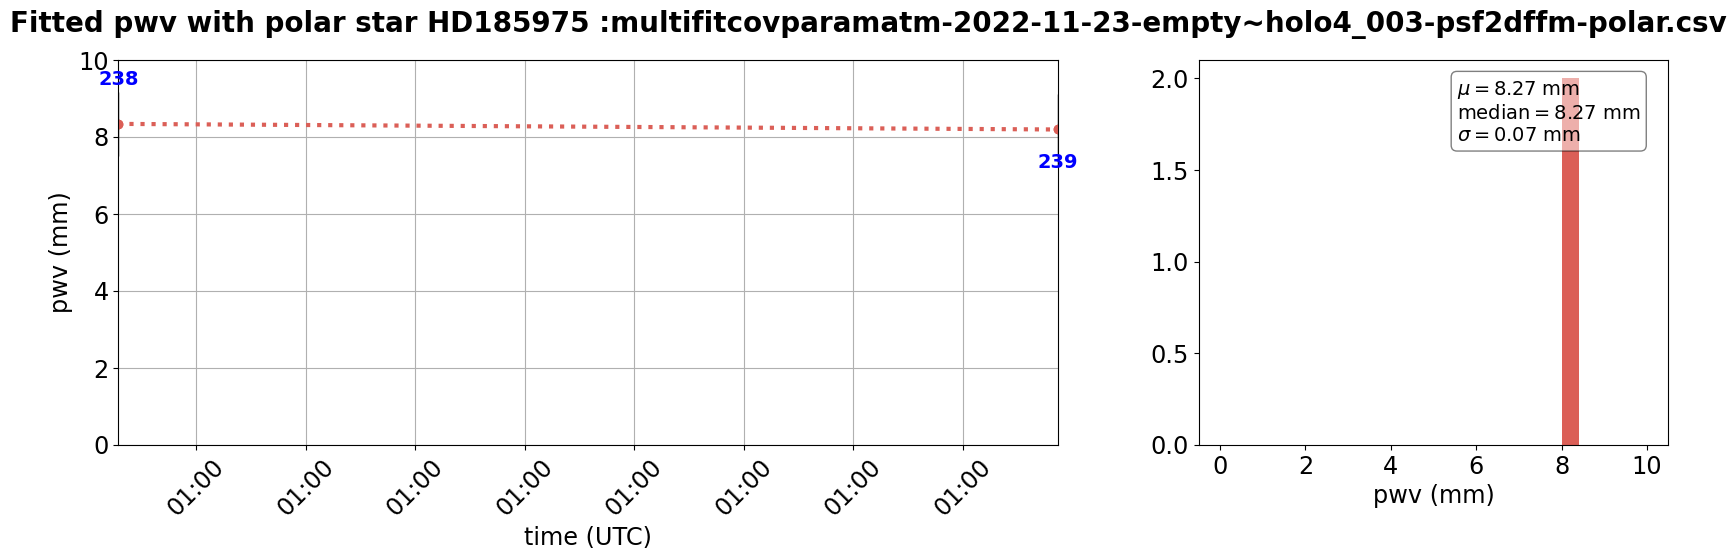

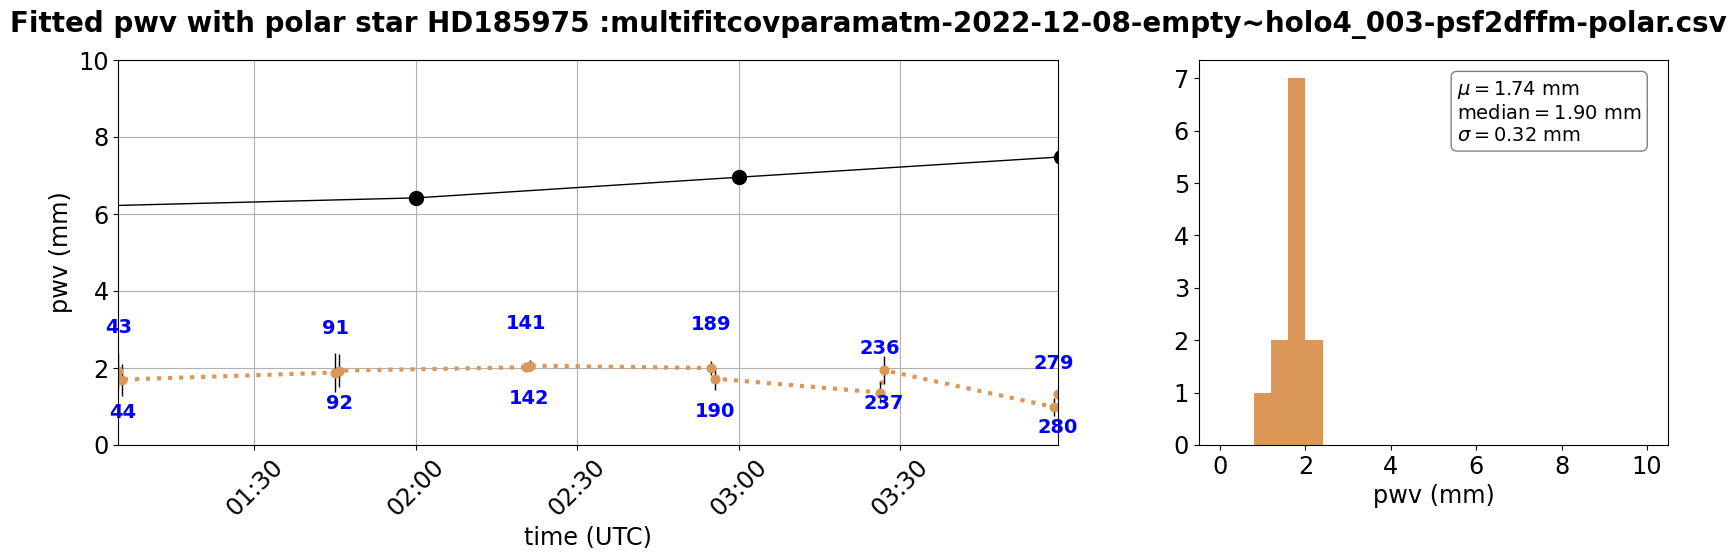

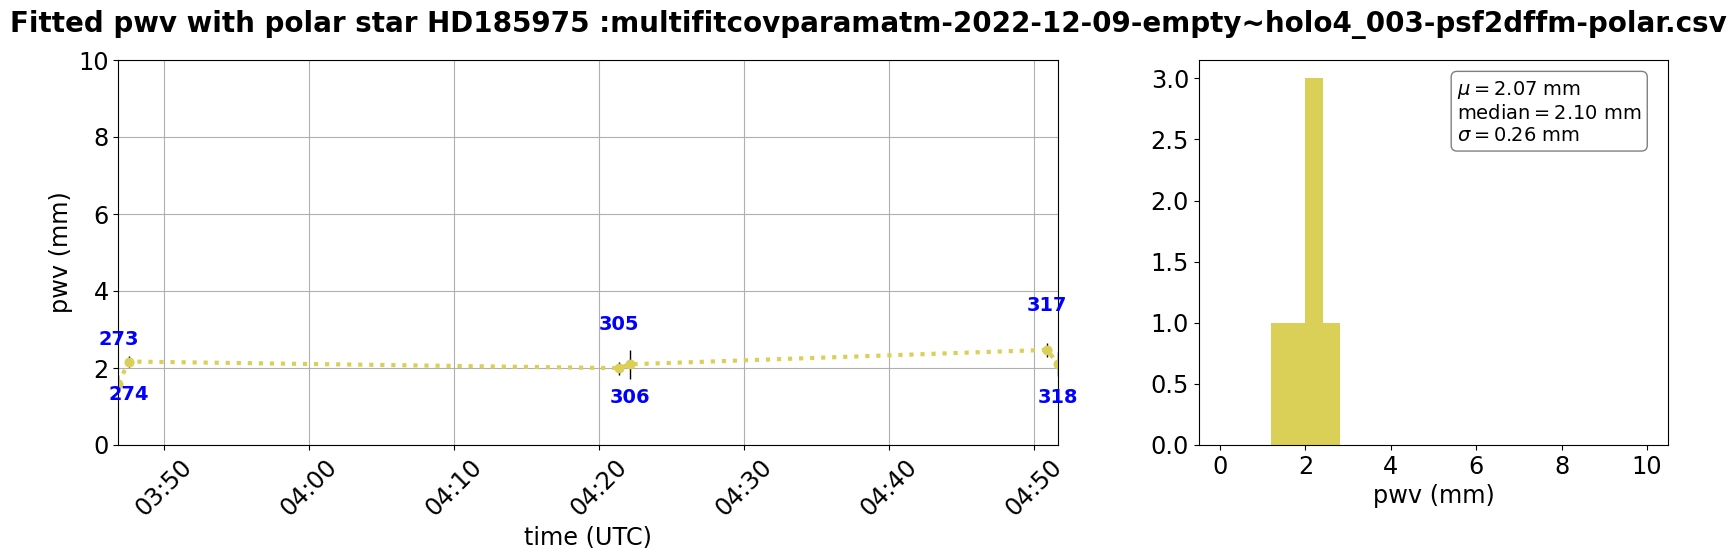

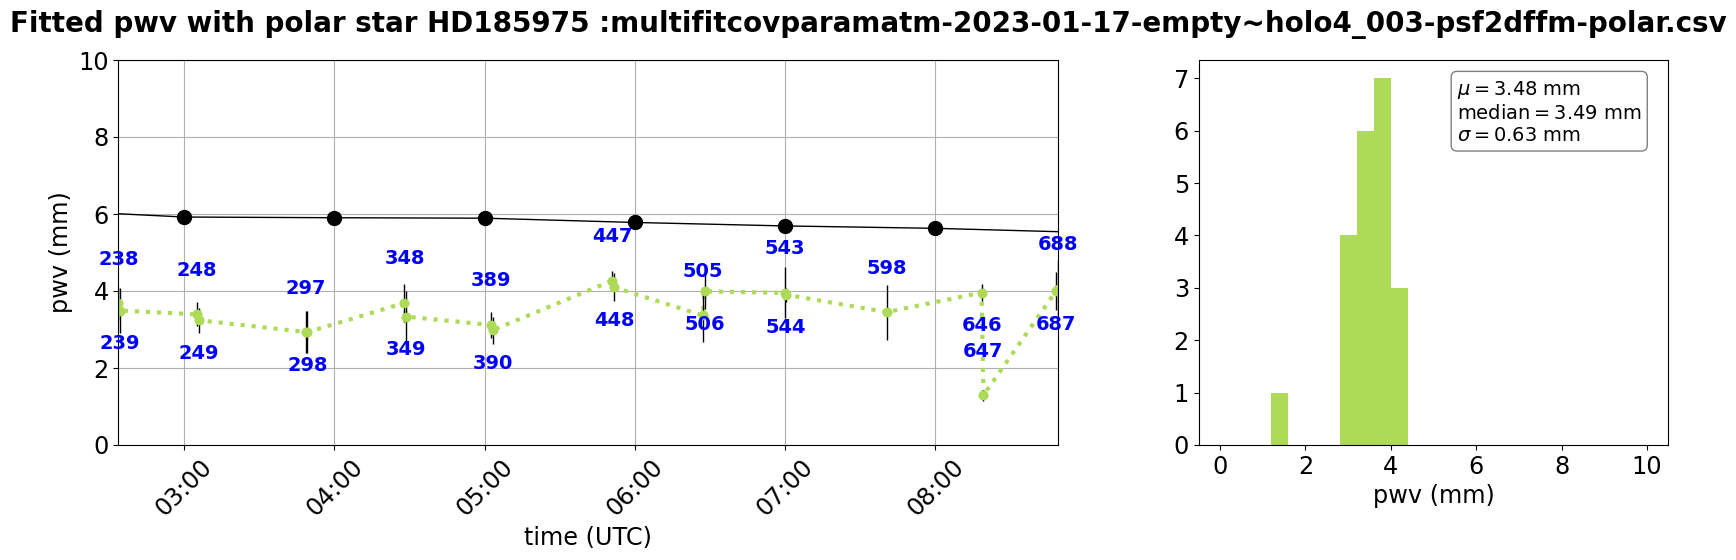

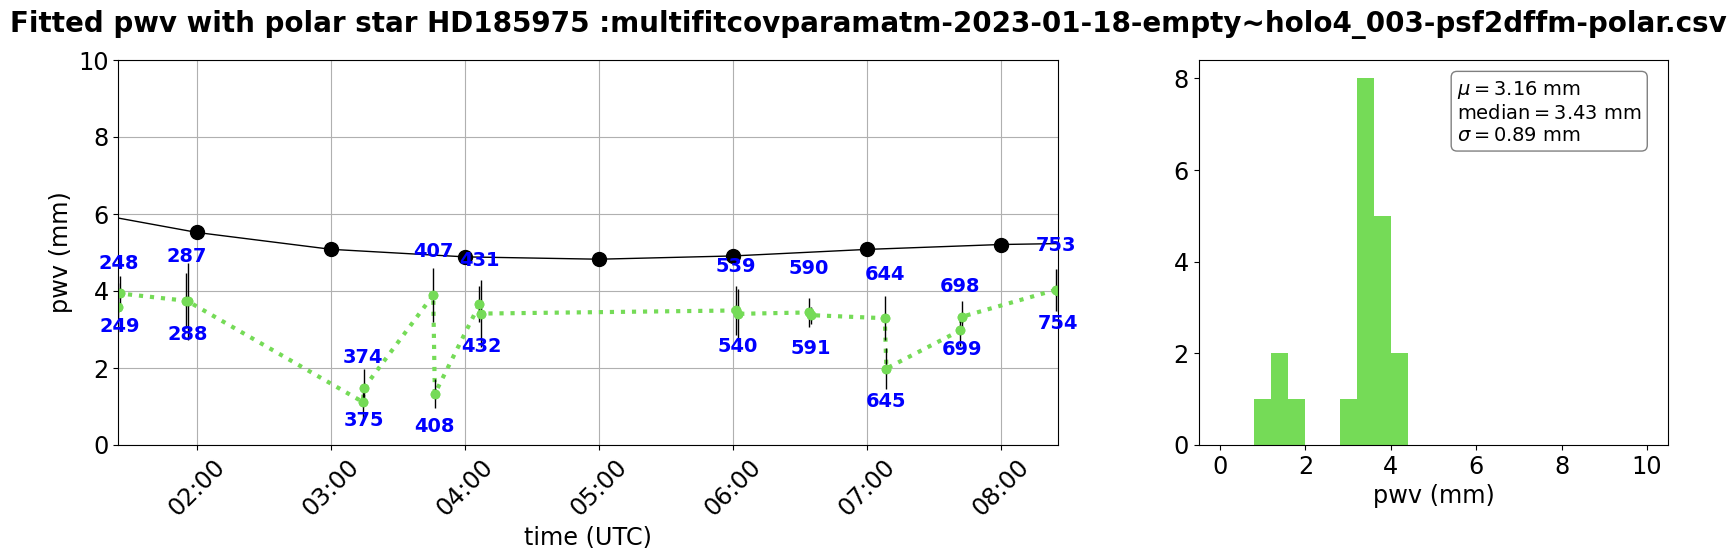

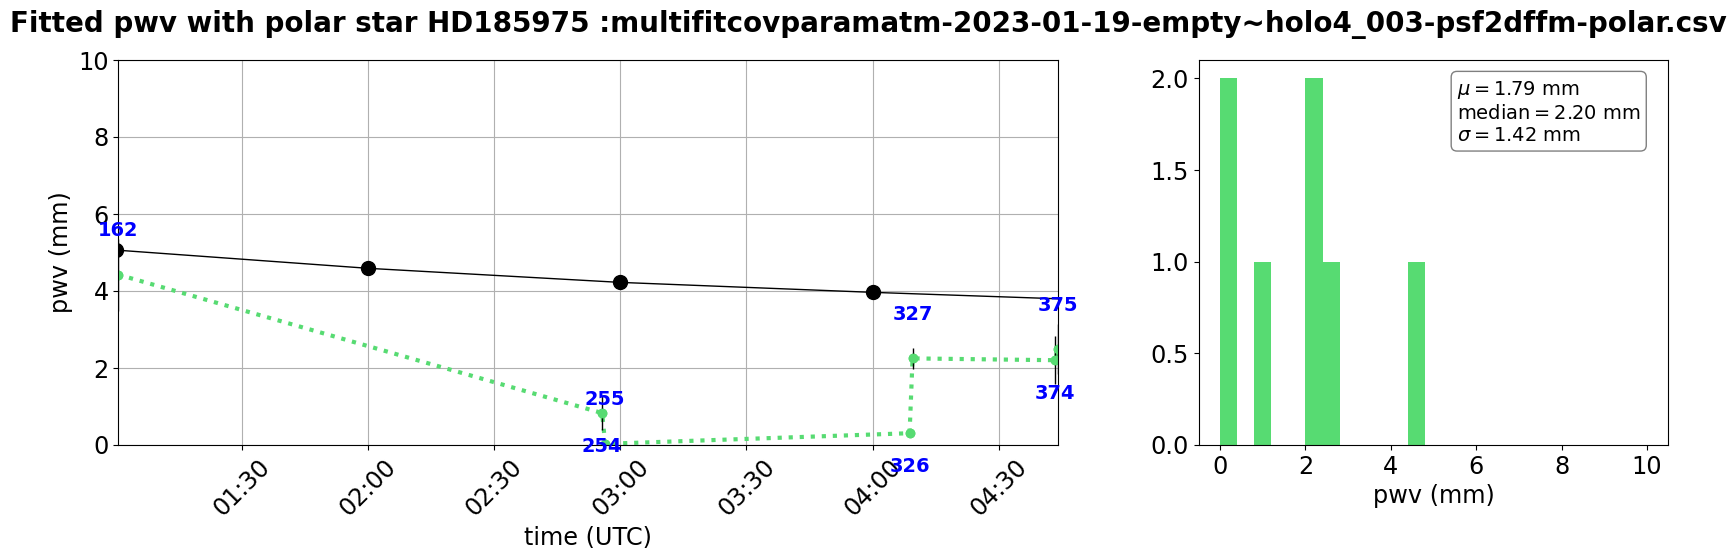

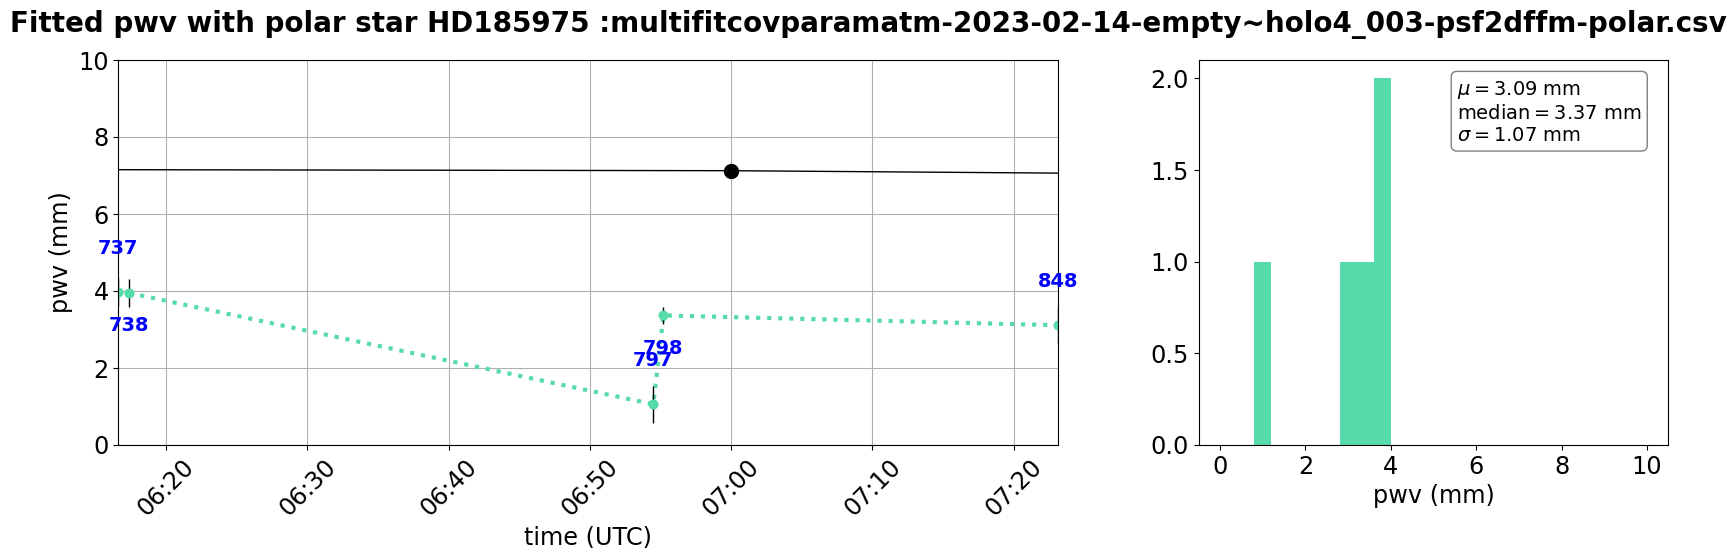

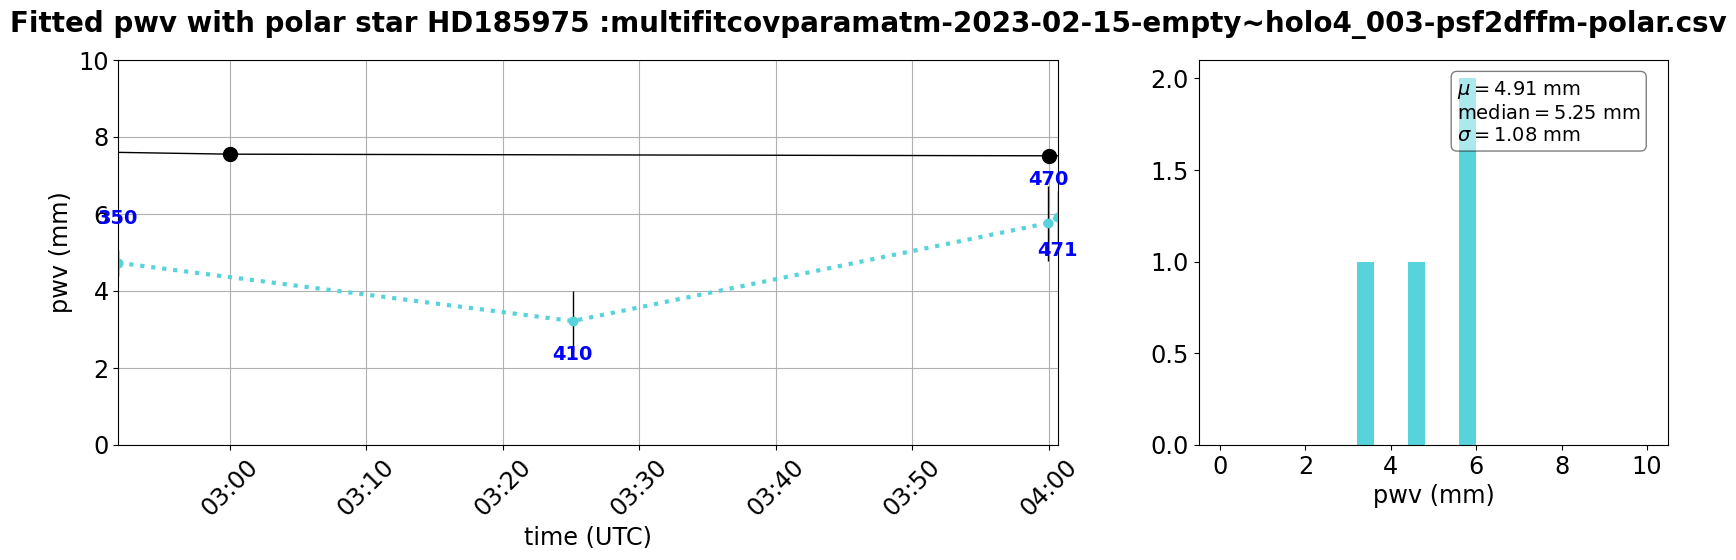

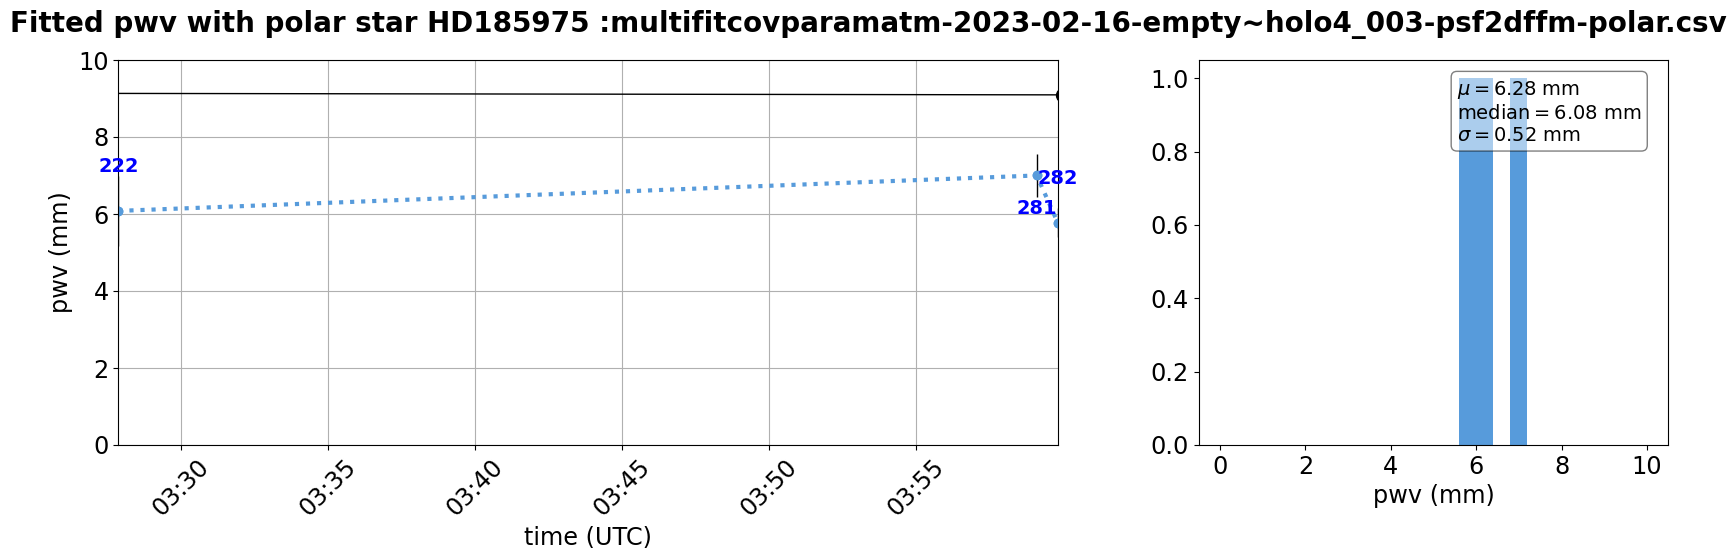

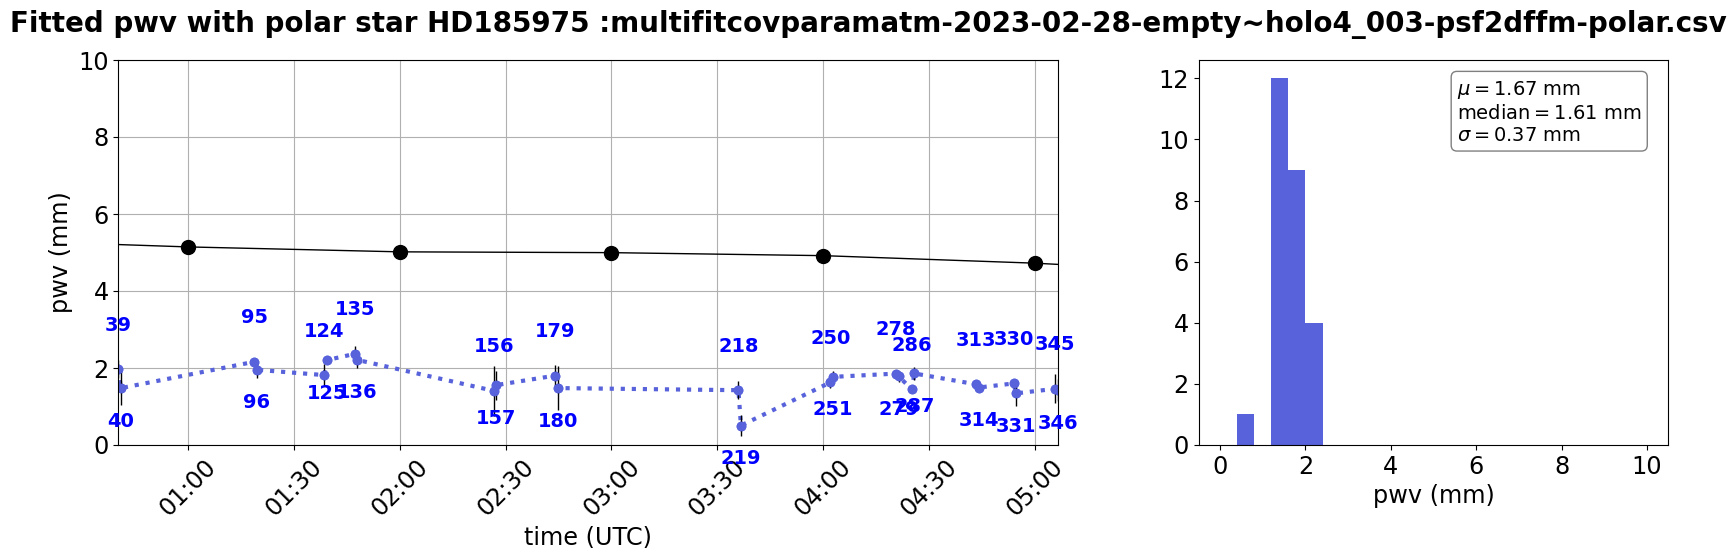

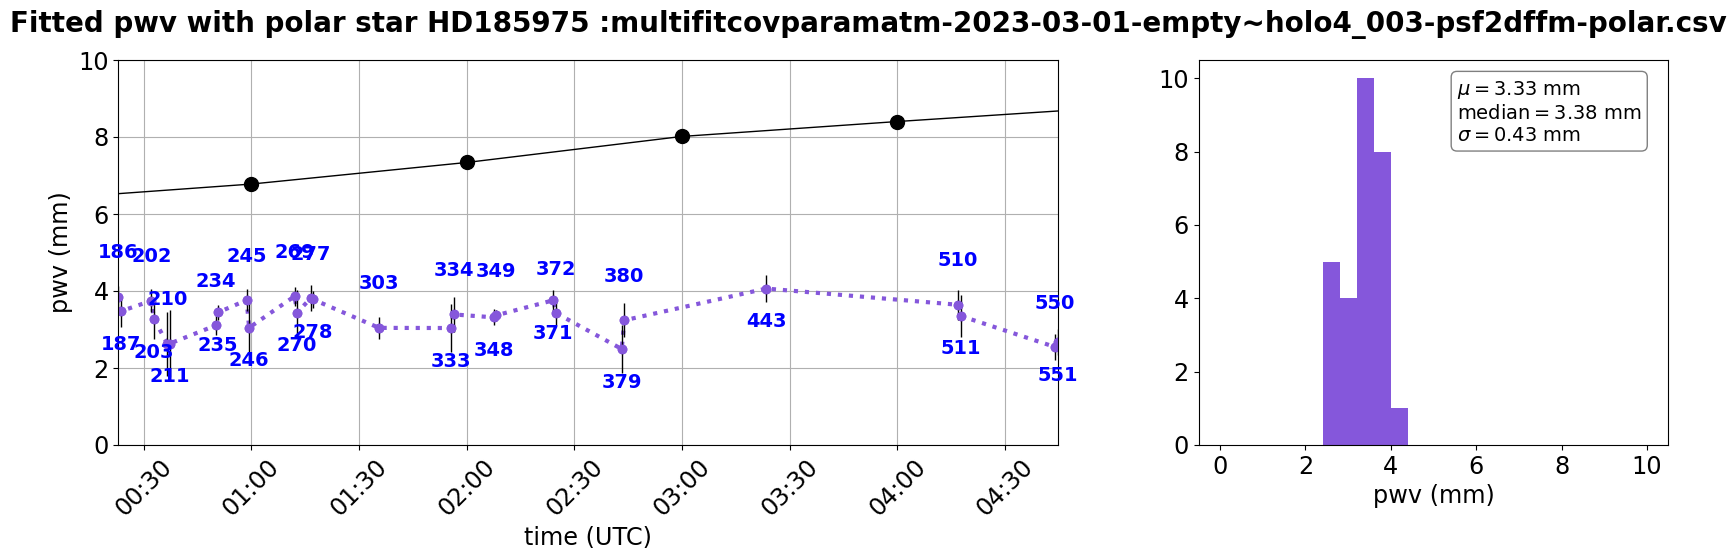

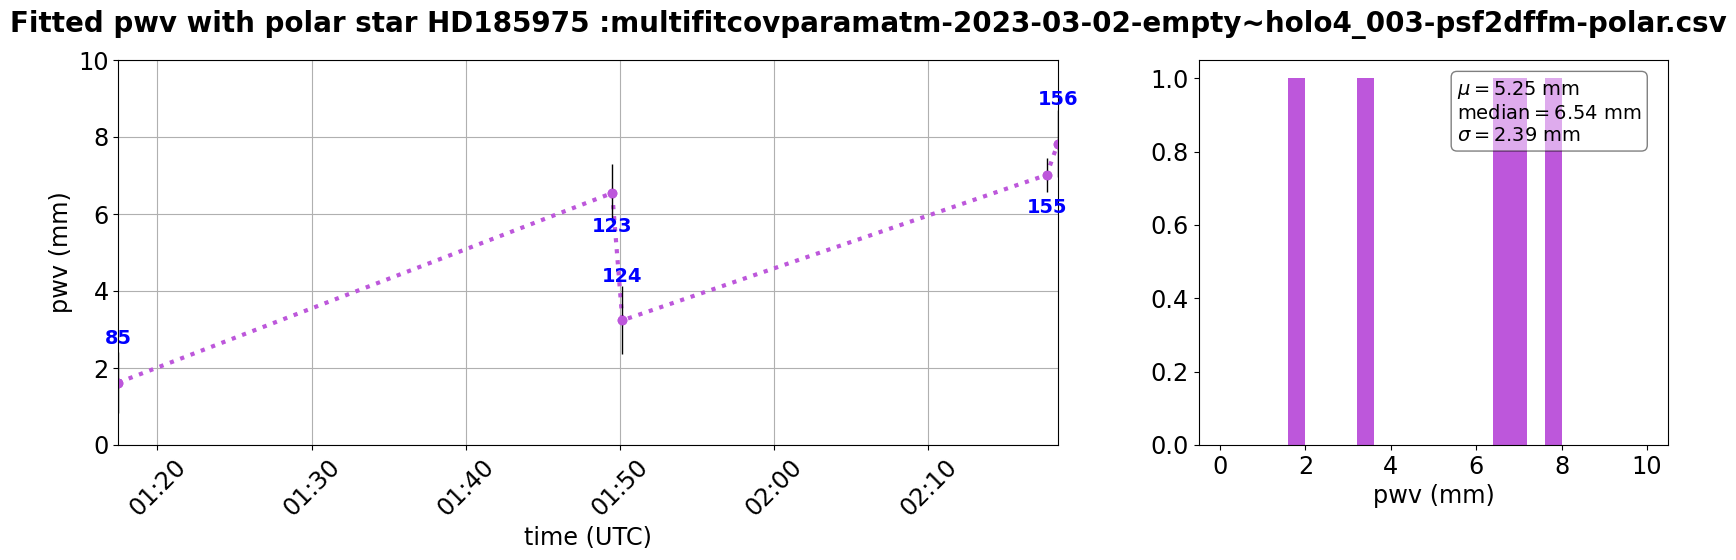

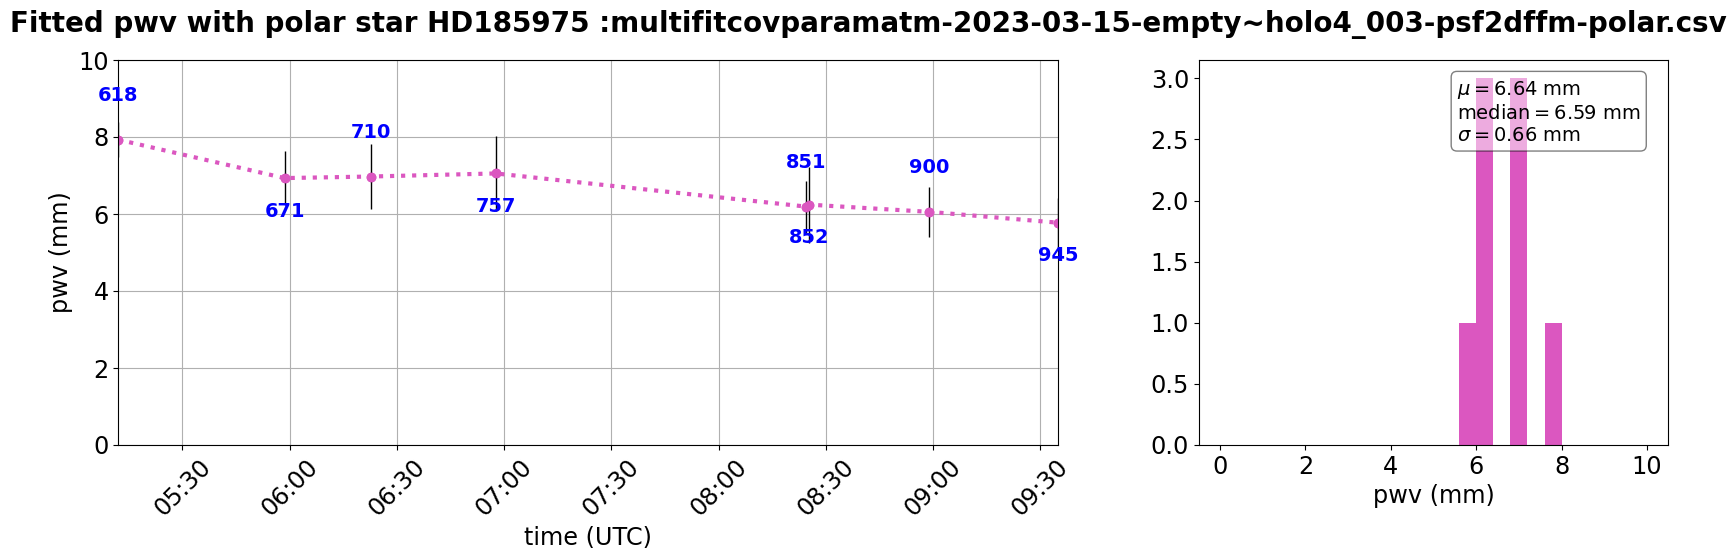

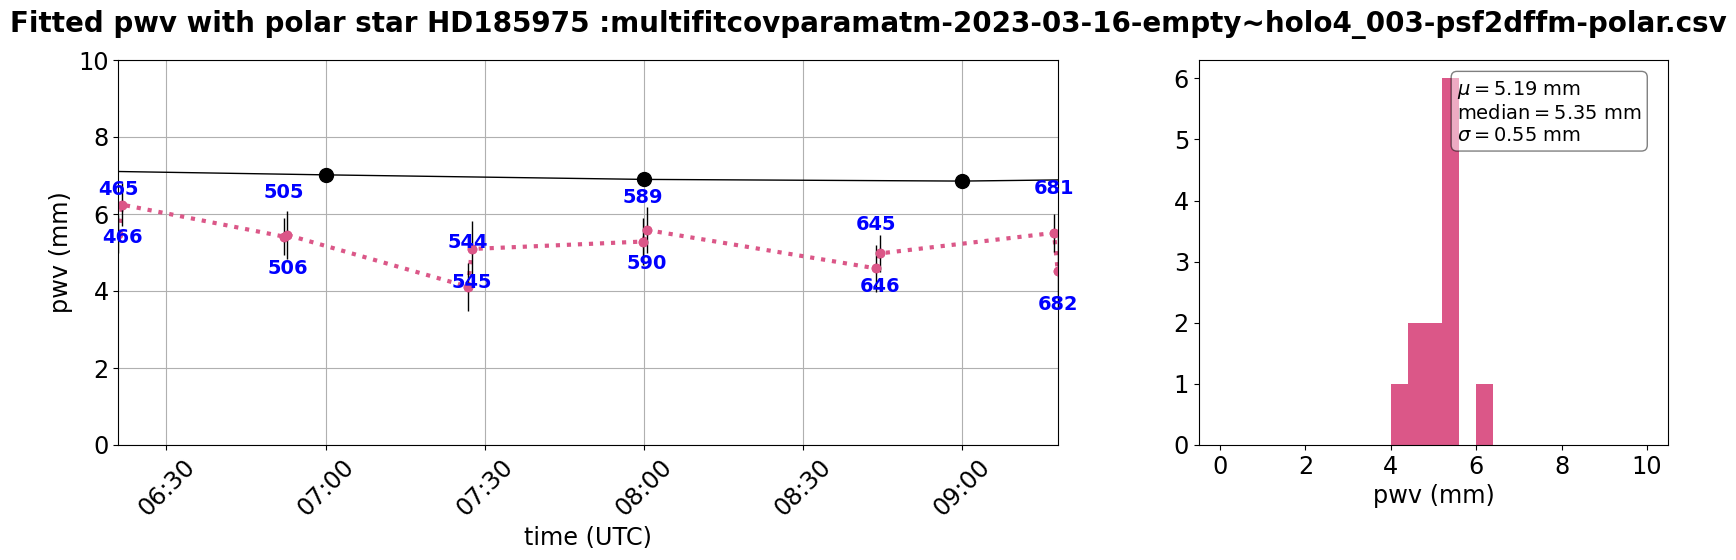

In [27]:
for idx,infos in enumerate(all_df):
    
    all_datetime = [ Time(str_time).to_datetime() for str_time in infos['spec_date_obs'] ]
    numbers = infos['number'].values
    
    pwv= infos['pwv_avg'].values
    epwv= infos['pwv_sig'].values
    

    N= len(numbers)
    if N<1:
        continue
  
        

    # Create rectangle x coordinates
    startTime = all_datetime[0]
    endTime =  all_datetime[-1]

    # convert to matplotlib date representation
    start = mdates.date2num(startTime)
    end = mdates.date2num(endTime)
    width = end - start



    fig=plt.figure(figsize=(20,5))
    gs = gridspec.GridSpec(1, 2,width_ratios=[3,1.5],figure=fig)
    
    ax= fig.add_subplot(gs[0,0])
    myFmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(myFmt)
 

    y_shift= 1

  
    ax.plot(all_datetime,pwv,'r:o',color=hls_colors[idx],lw=3,label="Rubin Auxtel")
    ax.errorbar(all_datetime,pwv,yerr=epwv,fmt='o',color=hls_colors[idx],ecolor="k",lw=1,alpha=1,label="merra2")
    
    ax.plot(all_merra2_datetime,pwv_merra2 ,'k-o',markersize=10,lw=1,label="RERRA2(2022)")
    
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_xlabel("time (UTC)")
    ax.set_ylabel("pwv (mm)")
    ax.set_ylim(pwv.min()-2*y_shift,pwv.max()+2*y_shift)
    ax.set_xlim(start,end)
    # Plot rectangle
    #rect = plt.Rectangle((start, airmasses.min()-2*y_shift), width, airmasses.max()+ 2*y_shift, color='grey',alpha=0.3)
    #ax2.add_patch(rect)   
    #ax.invert_yaxis()
    ax.grid()
    ax.set_ylim(0.,10.)


    for index in range(N):
        textstr= str(numbers[index])
        
        if index%2 == 0:
            dy = y_shift
        else:
            dy = -y_shift
            
        ax.text(all_datetime[index], pwv[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color="b" )
    
    
    
    ax= fig.add_subplot(gs[0,1])
    ax.hist(pwv,bins=25,range=(0,10),facecolor=hls_colors[idx])
    ax.set_xlabel("pwv (mm)")
    
    mu = pwv.mean()
    median = np.median(pwv)
    sigma =pwv.std()
    
    textstr = '\n'.join((
    r'$\mu=%.2f$ mm' % (mu, ),
    r'$\mathrm{median}=%.2f$ mm' % (median, ),
    r'$\sigma=%.2f$ mm' % (sigma, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.55, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

    
    
    
    if FLAG_SELECT_POLAR:
        the_title = "Fitted pwv with polar star HD185975 :" + filenames[idx]
    else:
        the_title = "Fitted pwv with all stars :" + filenames[idx]
    plt.suptitle(the_title,fontsize="20",fontweight="bold")
    plt.show()
    
    

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_43988/2185353410.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r:o" (-> color='r'). The keyword argument will take precedence.
  ax.plot(all_datetime,pwv,'r:o',color=hls_colors[idx],lw=3,label="Rubin Auxtel " + tags[idx])


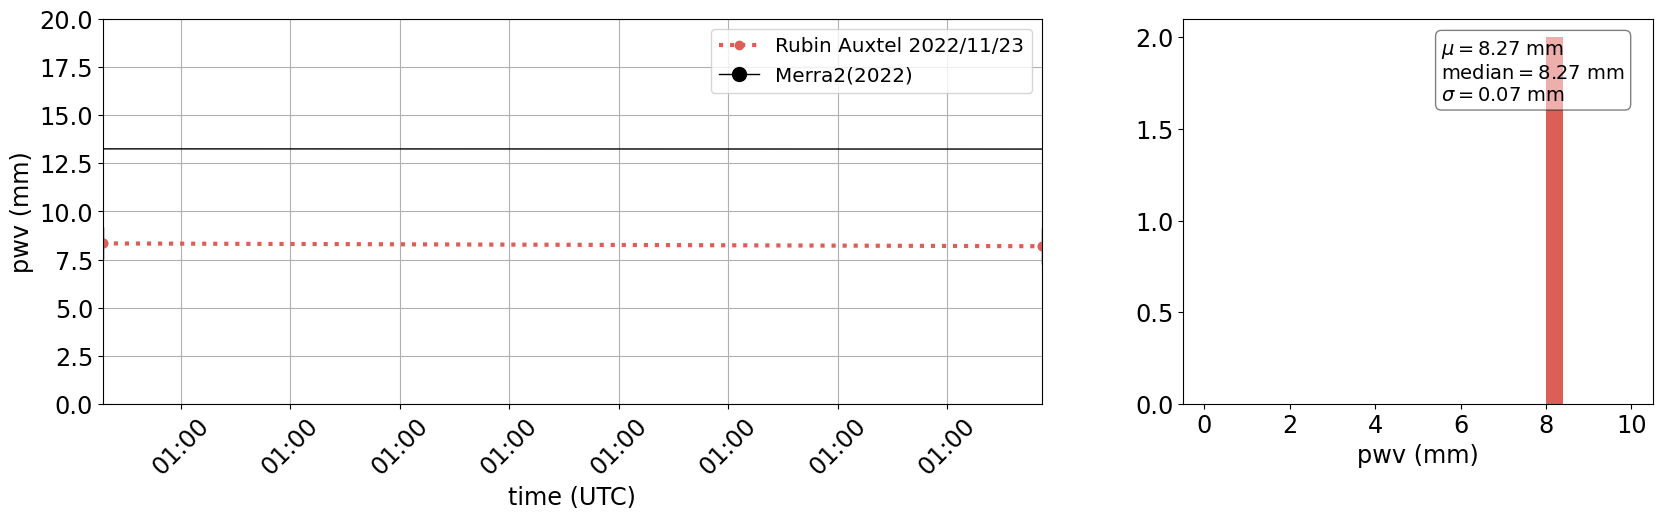

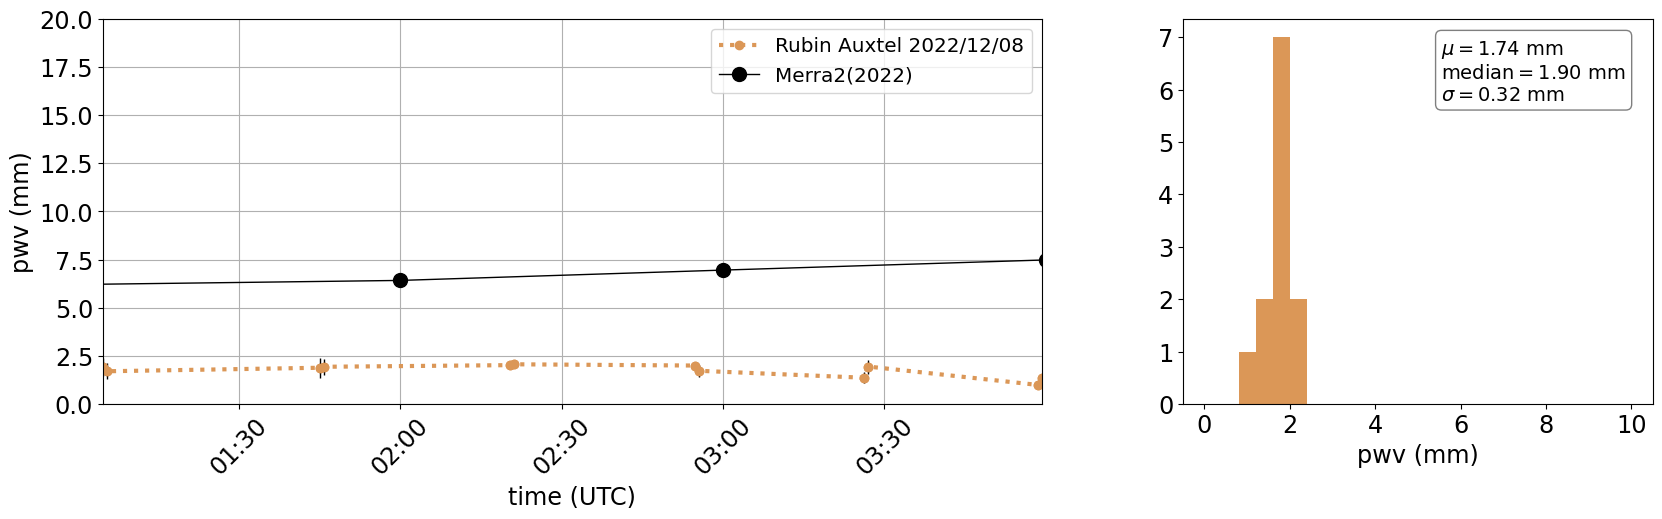

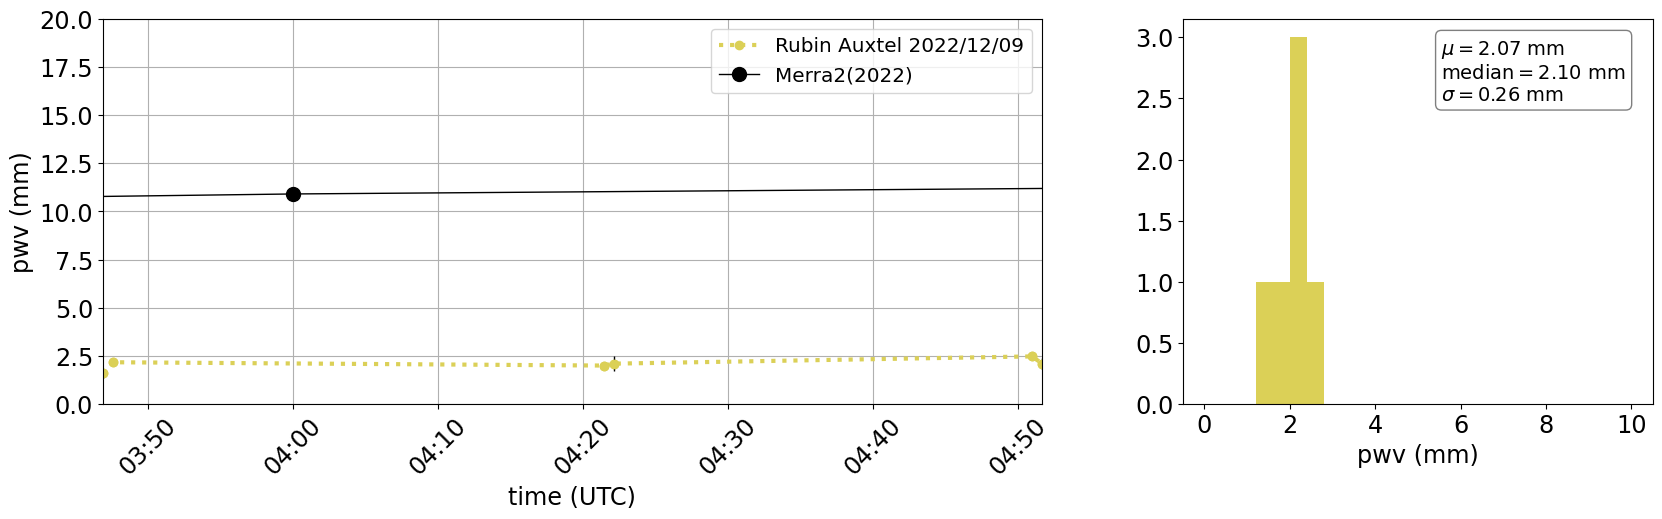

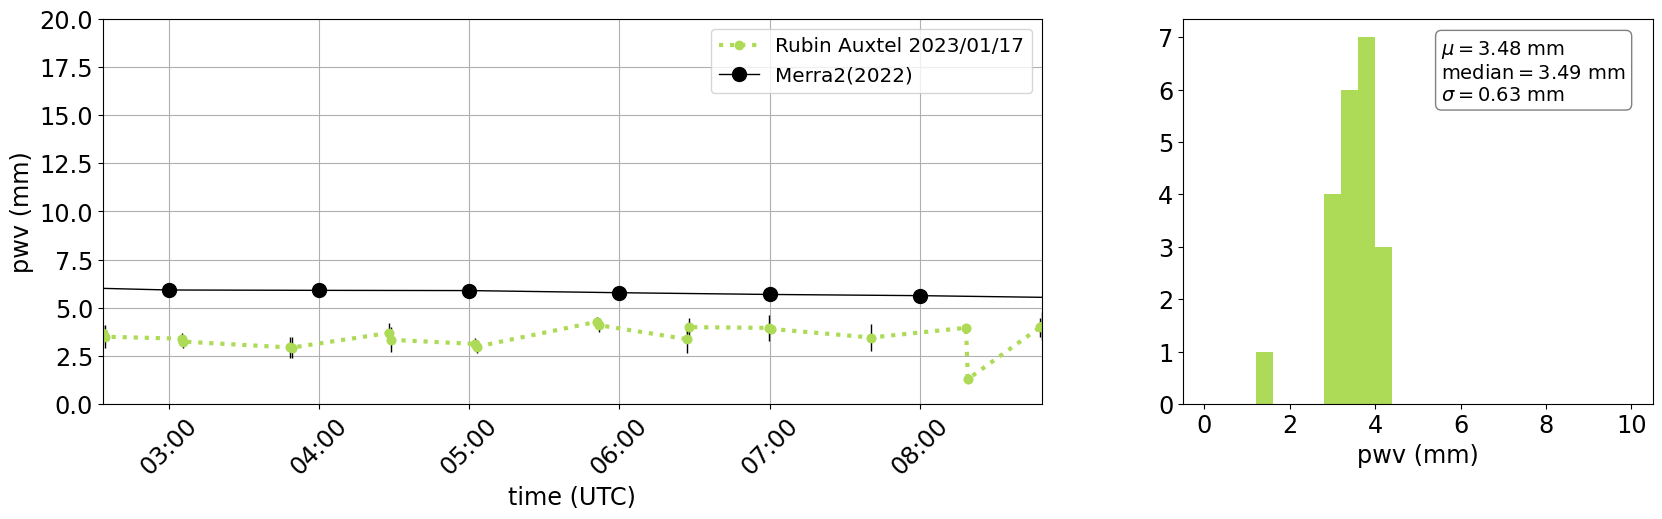

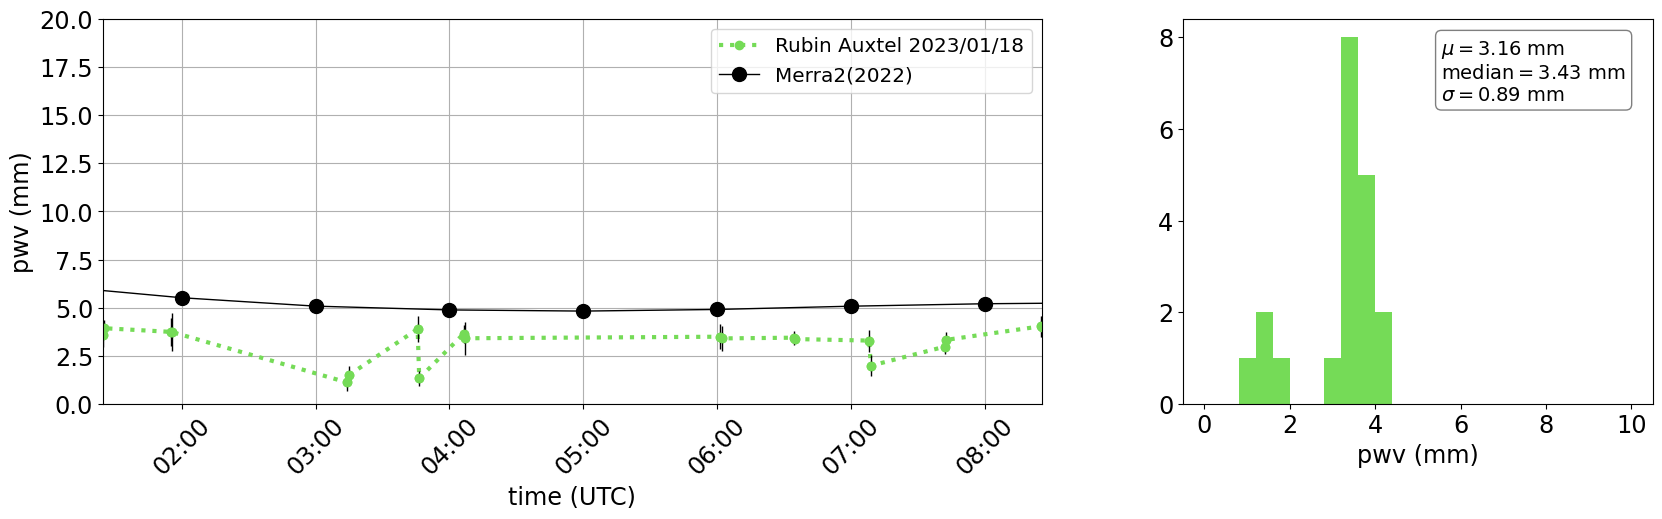

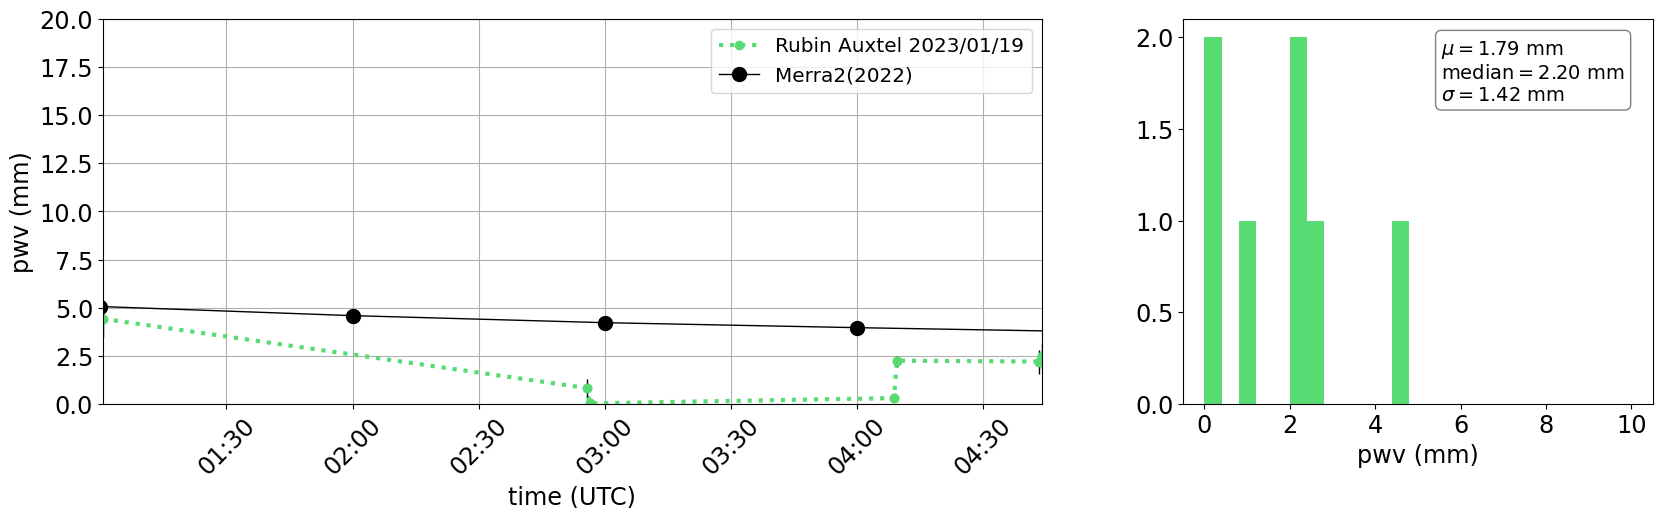

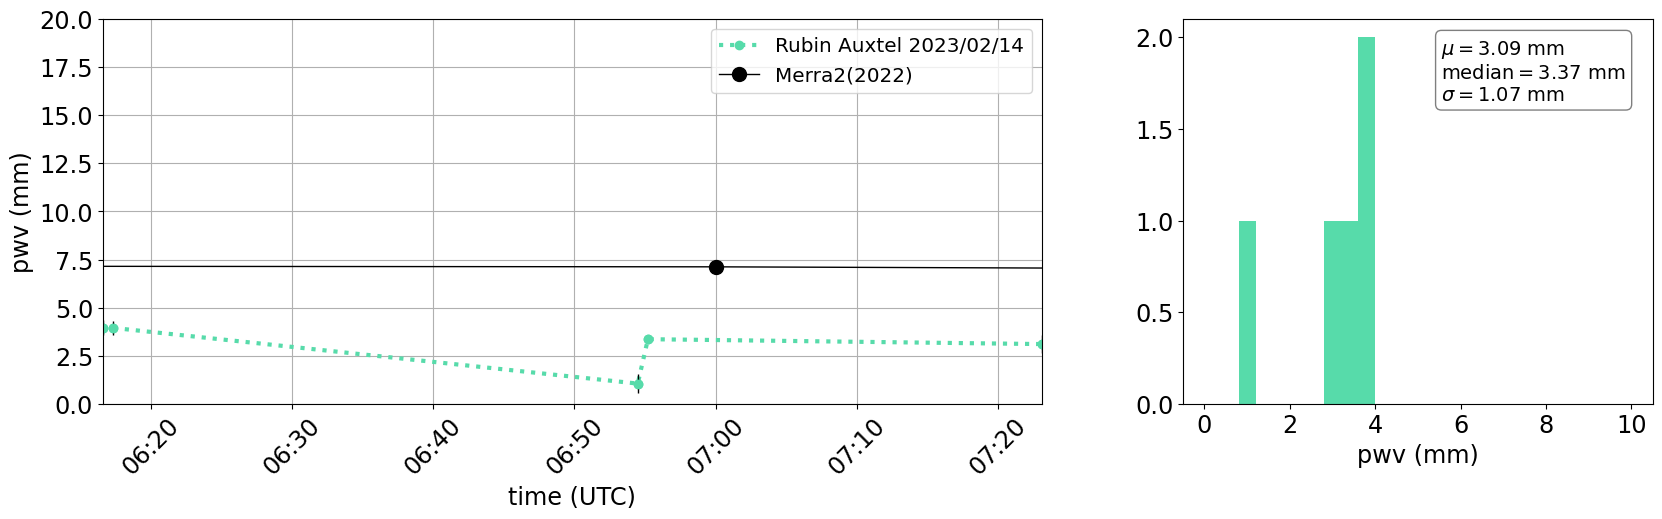

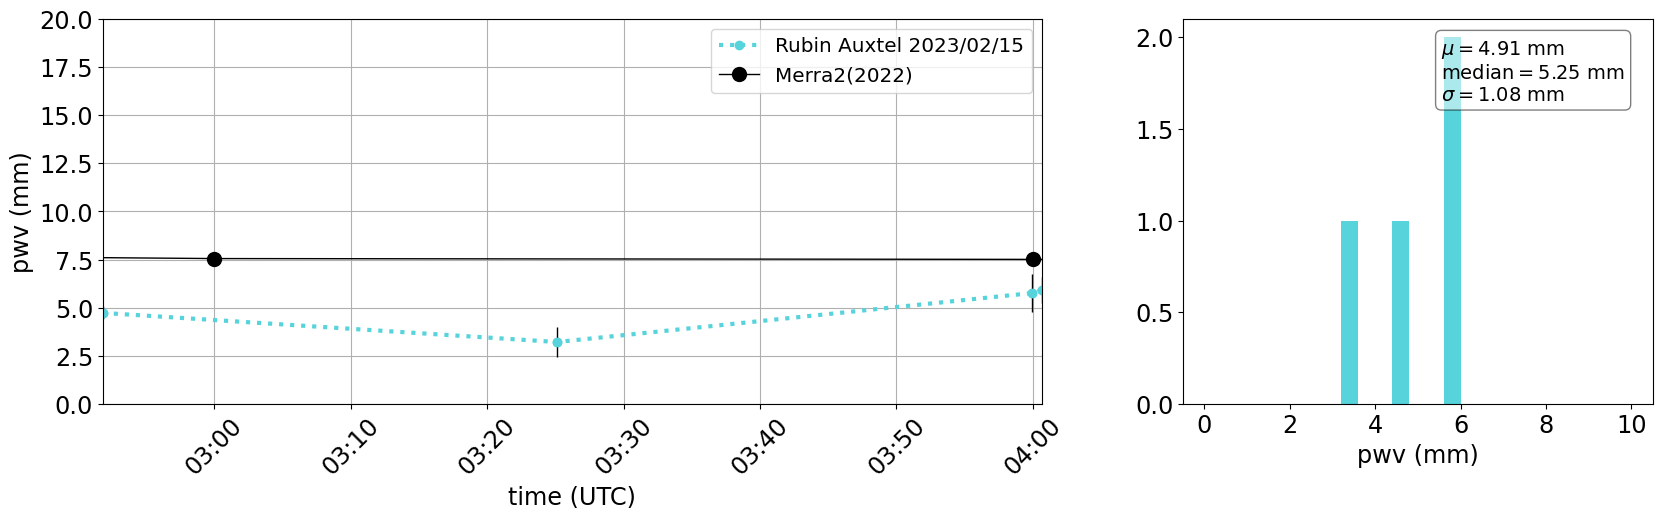

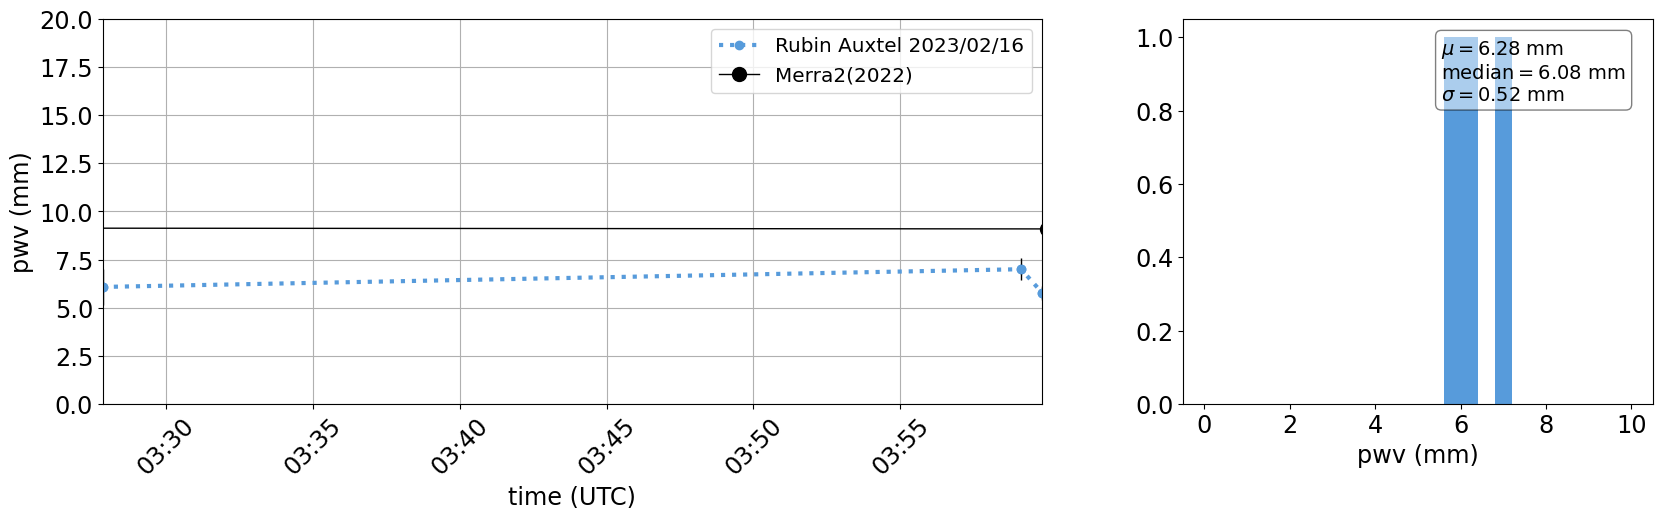

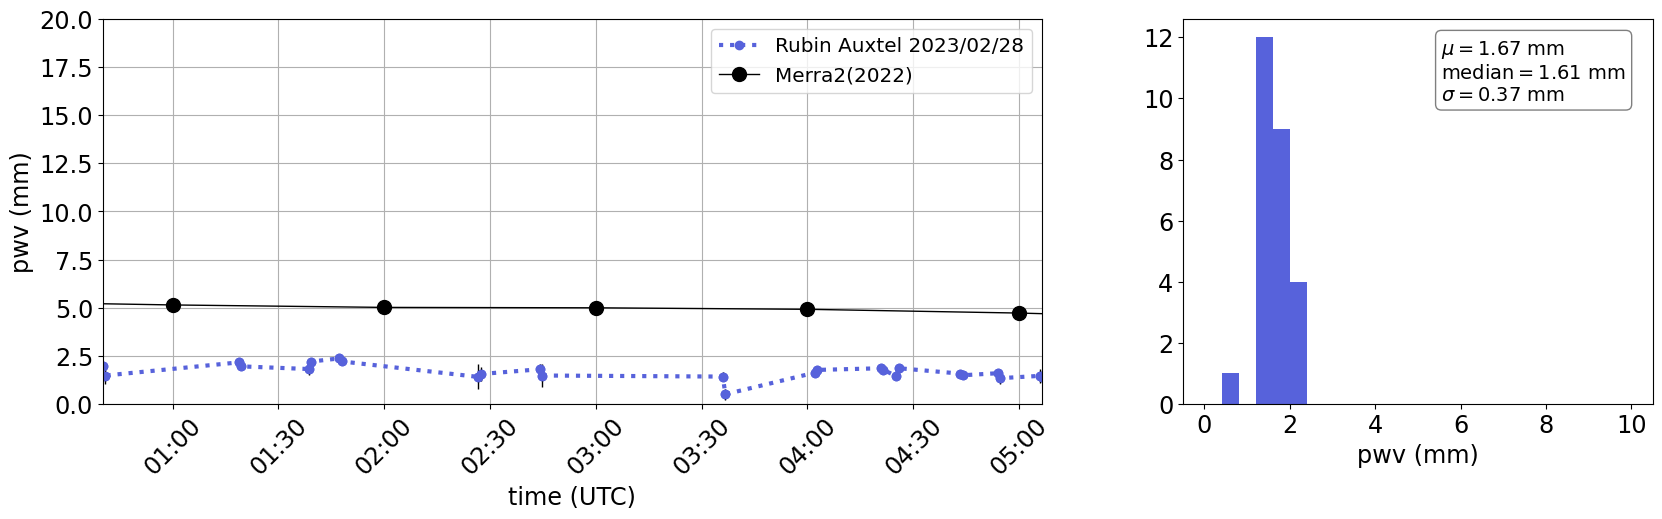

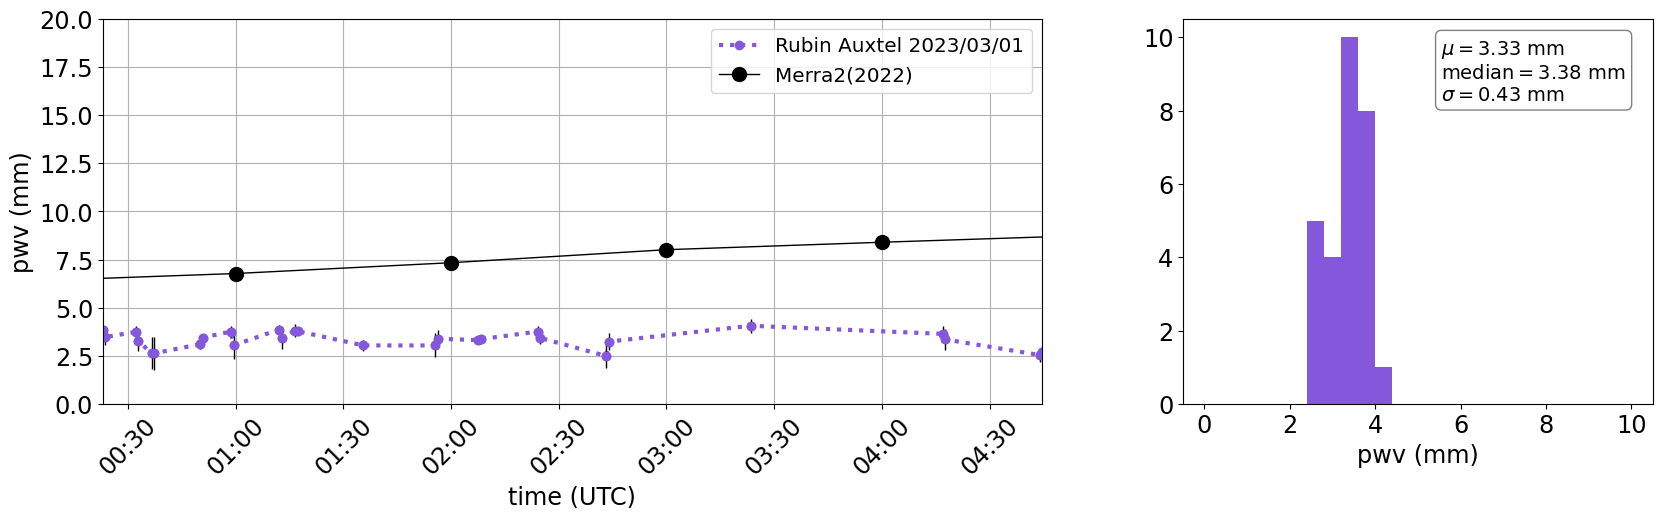

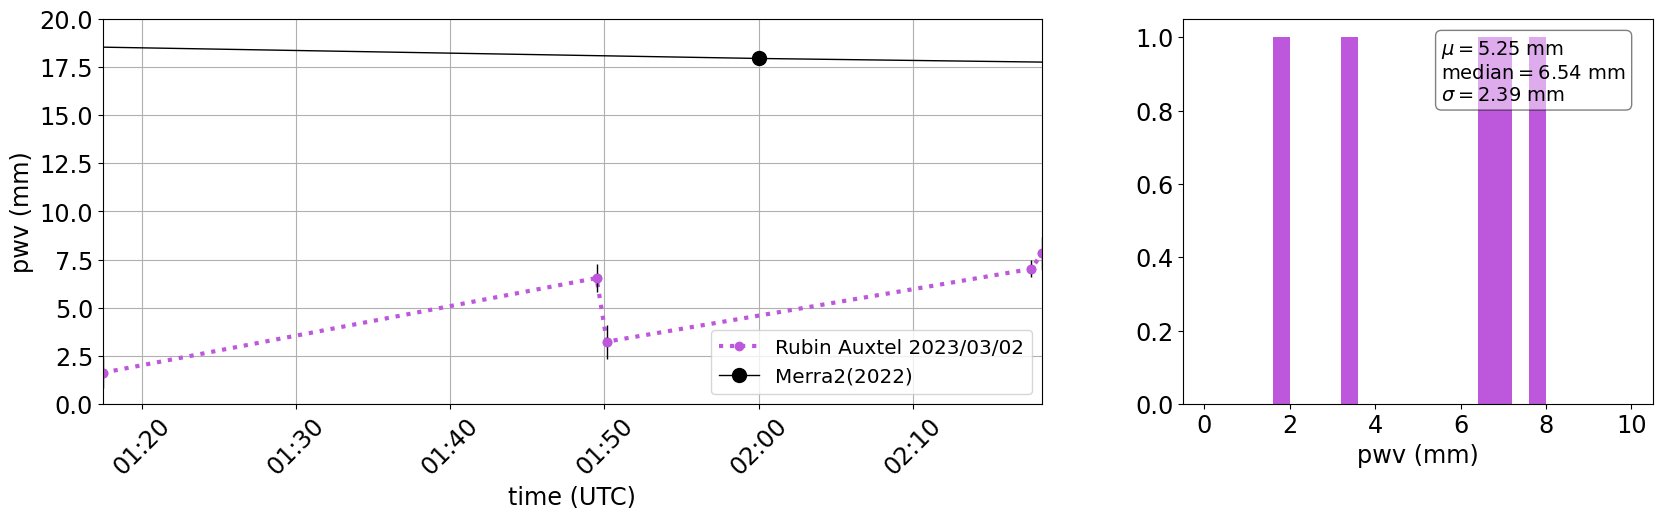

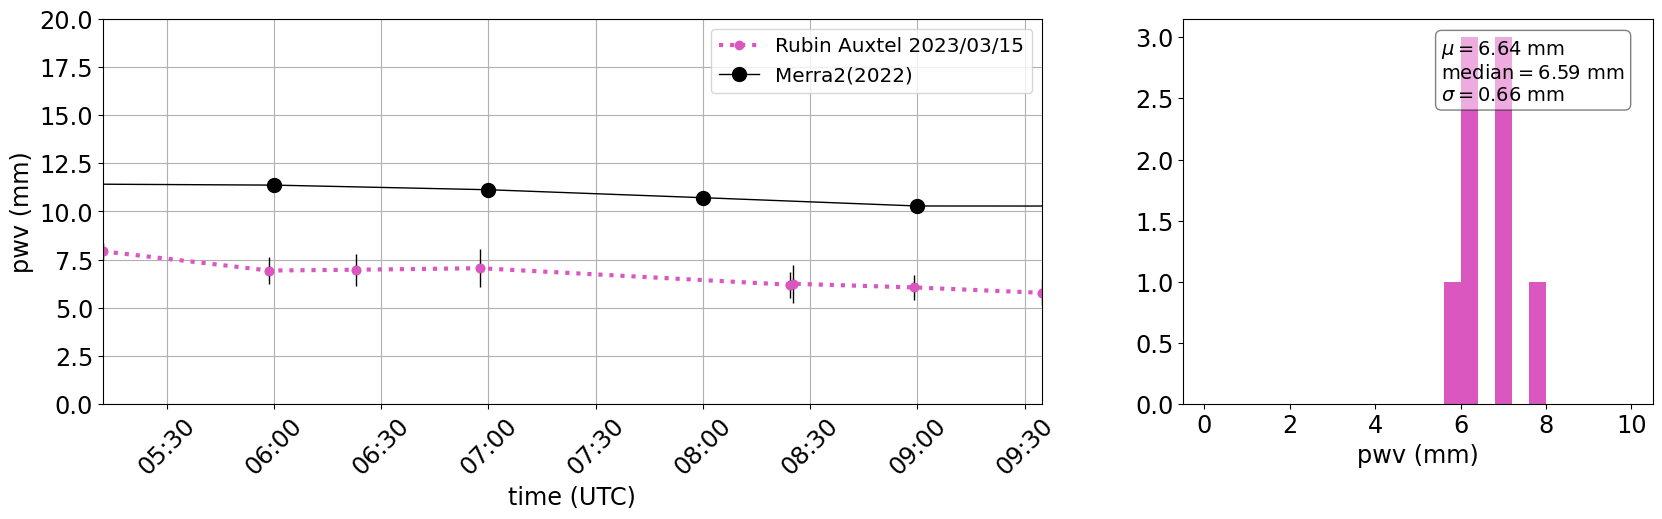

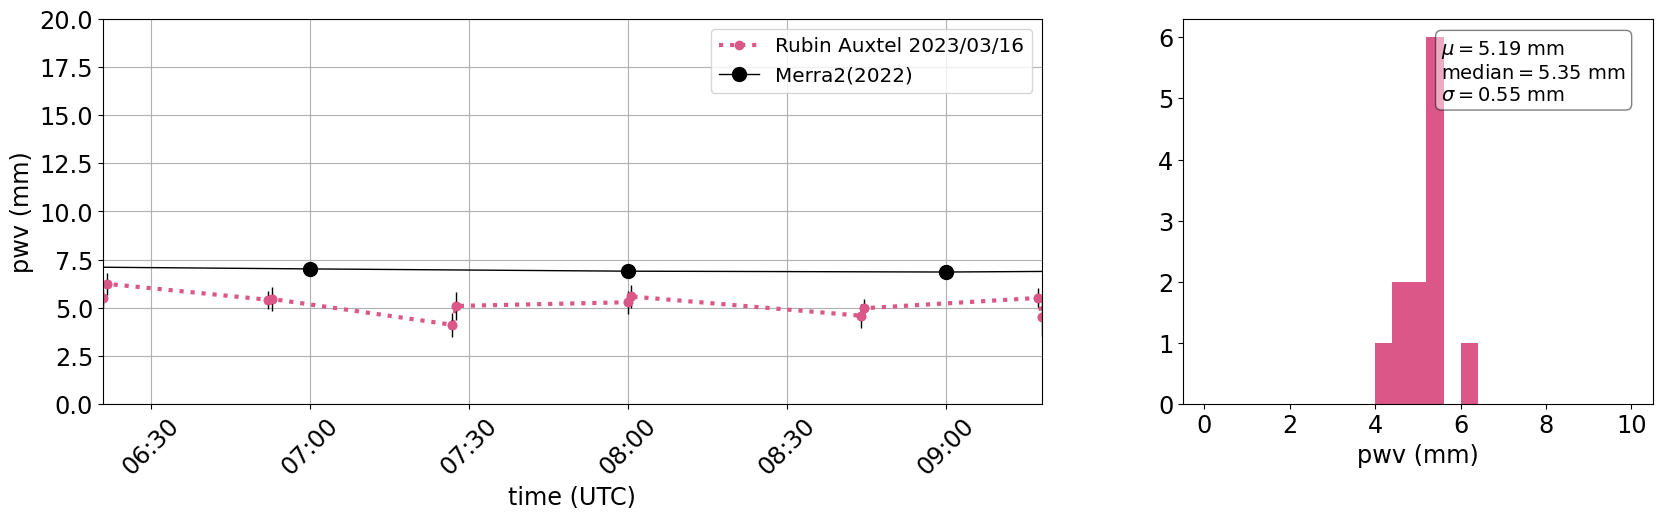

In [32]:
for idx,infos in enumerate(all_df):
    
    all_datetime = [ Time(str_time).to_datetime() for str_time in infos['spec_date_obs'] ]
    numbers = infos['number'].values
    
    pwv= infos['pwv_avg'].values
    epwv= infos['pwv_sig'].values
    

    N= len(numbers)
    if N<1:
        continue
  
        

    # Create rectangle x coordinates
    startTime = all_datetime[0]
    endTime =  all_datetime[-1]

    # convert to matplotlib date representation
    start = mdates.date2num(startTime)
    end = mdates.date2num(endTime)
    width = end - start



    fig=plt.figure(figsize=(20,5))
    gs = gridspec.GridSpec(1, 2,width_ratios=[3,1.5],figure=fig)
    
    ax= fig.add_subplot(gs[0,0])
    myFmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(myFmt)
 



  
    ax.plot(all_datetime,pwv,'r:o',color=hls_colors[idx],lw=3,label="Rubin Auxtel " + tags[idx])
    ax.errorbar(all_datetime,pwv,yerr=epwv,fmt='o',color=hls_colors[idx],ecolor="k",lw=1,alpha=1)
    
    ax.plot(all_merra2_datetime,pwv_merra2 ,'k-o',markersize=10,lw=1,label="Merra2(2022)")
    
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_xlabel("time (UTC)")
    ax.set_ylabel("pwv (mm)")
    ax.legend()

    ax.set_xlim(start,end)
    # Plot rectangle
    #rect = plt.Rectangle((start, airmasses.min()-2*y_shift), width, airmasses.max()+ 2*y_shift, color='grey',alpha=0.3)
    #ax2.add_patch(rect)   
    #ax.invert_yaxis()
    ax.grid()
    ax.set_ylim(0.,20.)


    
    
    
    ax= fig.add_subplot(gs[0,1])
    ax.hist(pwv,bins=25,range=(0,10),facecolor=hls_colors[idx])
    ax.set_xlabel("pwv (mm)")
    
    mu = pwv.mean()
    median = np.median(pwv)
    sigma =pwv.std()
    
    textstr = '\n'.join((
    r'$\mu=%.2f$ mm' % (mu, ),
    r'$\mathrm{median}=%.2f$ mm' % (median, ),
    r'$\sigma=%.2f$ mm' % (sigma, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.55, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

    
    
    
    if FLAG_SELECT_POLAR:
        the_title = "Fitted pwv with polar star HD185975 : " + tags[idx]
    else:
        the_title = "Fitted pwv with all stars : " + tags[idx]
    #plt.suptitle(the_title,fontsize="20",fontweight="bold")
    plt.show()
    
    

In [29]:
len(all_df)

14

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_43988/378934554.py:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r:o" (-> color='r'). The keyword argument will take precedence.
  ax.plot(all_datetime,pwv,'r:o',color=hls_colors[idx],lw=3,label="Rubin Auxtel " + tags[idx])


IndexError: index 9 is out of bounds for axis 0 with size 9

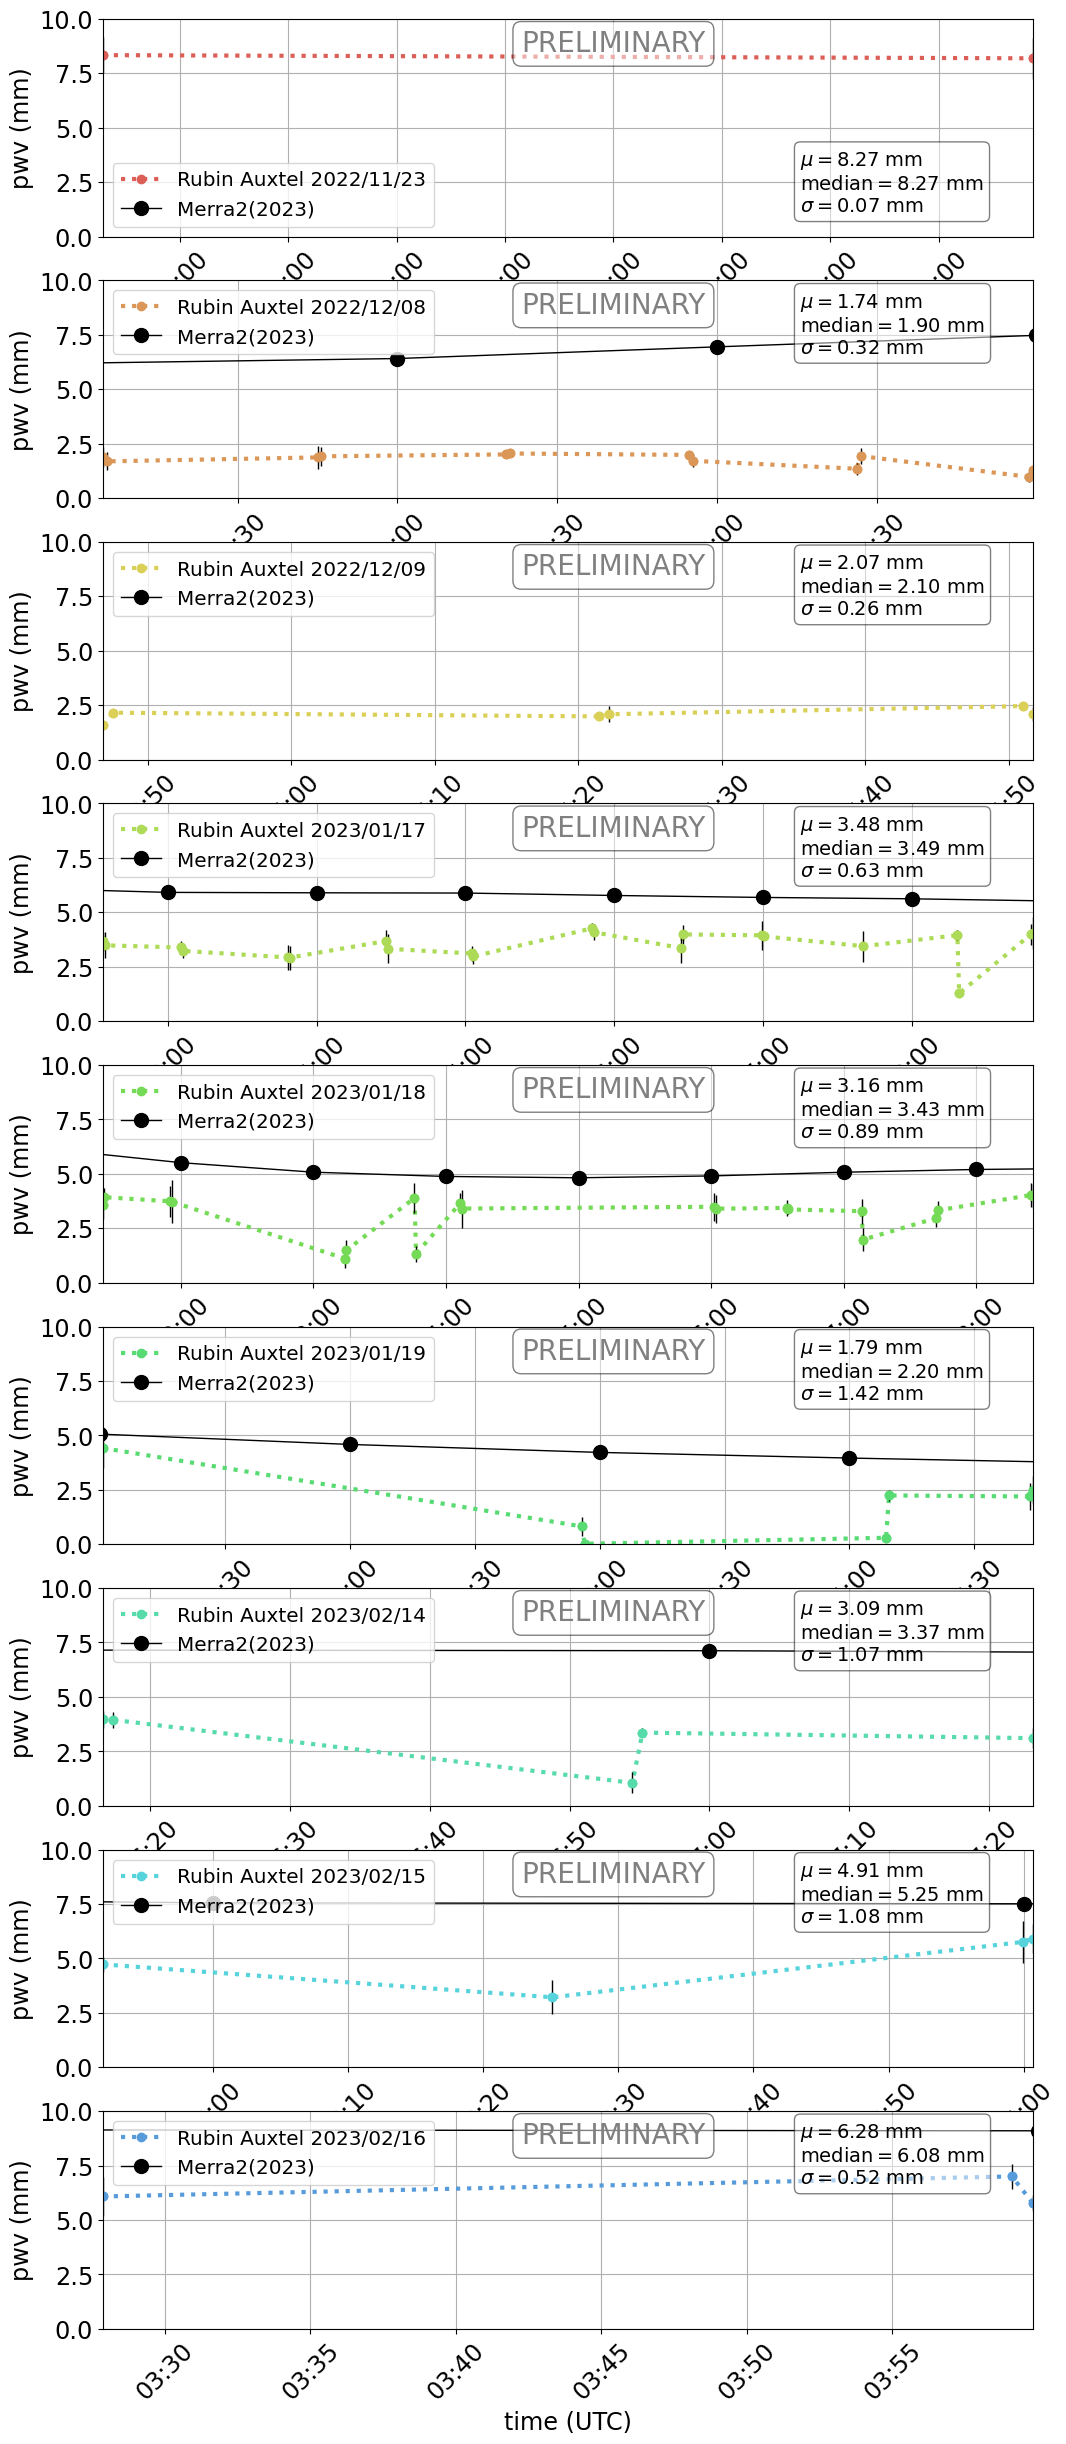

In [30]:
fig = plt.figure(figsize=(12,30))

gs = gridspec.GridSpec(9, 1,height_ratios=[1,1,1,1,1,1,1,1,1],figure=fig)


for idx,infos in enumerate(all_df):
    
    
    all_datetime = [ Time(str_time).to_datetime() for str_time in infos['spec_date_obs'] ]
    numbers = infos['number'].values
    
    pwv= infos['pwv_avg'].values
    epwv= infos['pwv_sig'].values
    
    mu = pwv.mean()
    median = np.median(pwv)
    sigma =pwv.std()
    
   
    

    N= len(numbers)
    if N<1:
        continue
  
        

    # Create rectangle x coordinates
    startTime = all_datetime[0]
    endTime =  all_datetime[-1]

    # convert to matplotlib date representation
    start = mdates.date2num(startTime)
    end = mdates.date2num(endTime)
    width = end - start

   
    
    ax= fig.add_subplot(gs[idx,0])
    
    myFmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(myFmt)
 
  
    ax.plot(all_datetime,pwv,'r:o',color=hls_colors[idx],lw=3,label="Rubin Auxtel " + tags[idx])
    ax.errorbar(all_datetime,pwv,yerr=epwv,fmt='o',color=hls_colors[idx],ecolor="k",lw=1,alpha=1)
    
    ax.plot(all_merra2_datetime,pwv_merra2 ,'k-o',markersize=10,lw=1,label="Merra2(2023)")
    
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_xlabel("time (UTC)")
    ax.set_ylabel("pwv (mm)")
    if idx == 0:
        ax.legend(loc='lower left')
    else:
        ax.legend(loc='upper left')
        
        
    textstr = '\n'.join((
    r'$\mu=%.2f$ mm' % (mu, ),
    r'$\mathrm{median}=%.2f$ mm' % (median, ),
    r'$\sigma=%.2f$ mm' % (sigma, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    if idx ==0:
        ax.text(0.75, 0.40, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
    else:
        ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        
    ax.text(0.45, 0.95, "PRELIMINARY", transform=ax.transAxes,color="grey" ,fontsize=20,verticalalignment='top', bbox=props)
        
    ax.set_xlim(start,end)
 
    ax.grid()
    ax.set_ylim(0.,10.)


plt.suptitle(tag_stars)
plt.tight_layout()
figname = f"fig_pwv_prelim-2023_{tag_stars}.png"
plt.savefig(figname)
plt.show()
    

# Compute average per night

## PWV

In [31]:
all_nights_pwvauxtel = np.zeros((len(all_df),3))
all_nights_pwvmerra2 = np.zeros((len(all_df),3))
all_night_N = np.zeros(len(all_df))
all_labels = []

for idx,infos in enumerate(all_df):
    
    all_night_N[idx] = len(infos) 
    all_labels.append(tags[idx])
    
    if len(infos) == 0:
        all_nights_pwvauxtel[idx,0] = np.nan
        all_nights_pwvauxtel[idx,1] = np.nan
        all_nights_pwvauxtel[idx,2] = np.nan
        
        all_nights_pwvmerra2[idx,0] = np.nan
        all_nights_pwvmerra2[idx,1] = np.nan
        all_nights_pwvmerra2[idx,2] = np.nan
        
        continue
        
    
    all_datetime = [ Time(str_time).to_datetime() for str_time in infos['spec_date_obs'] ]
    numbers = infos['number'].values
    
    pwv= infos['pwv_avg'].values
    epwv= infos['pwv_sig'].values
    
    
    
    mu = pwv.mean()
    median = np.median(pwv)
    sigma =pwv.std()
    
    all_nights_pwvauxtel[idx,0] = mu
    all_nights_pwvauxtel[idx,1] = median
    all_nights_pwvauxtel[idx,2] = sigma
        

    # Create rectangle x coordinates
    startTime = all_datetime[0]
    endTime =  all_datetime[-1]
    
    
    night_pwv_merra2 = []
    for idx_m2,dattim_m2 in enumerate(all_merra2_datetime):
        if dattim_m2 >= startTime and dattim_m2 <= endTime:
            night_pwv_merra2.append(pwv_merra2.iloc[idx_m2]) 
        
    night_pwv_merra2=np.array(night_pwv_merra2)
    
    mu_m = night_pwv_merra2.mean()
    median_m = np.median(night_pwv_merra2)
    sigma_m =night_pwv_merra2.std()
    
    all_nights_pwvmerra2[idx,0] = mu_m
    all_nights_pwvmerra2[idx,1] = median_m
    all_nights_pwvmerra2[idx,2] = sigma_m
    
    

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_43988/3736776466.py:52: RuntimeWarning: Mean of empty slice.
  mu_m = night_pwv_merra2.mean()
/Users/sylvie/mambaforge/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/sylvie/mambaforge/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sylvie/mambaforge/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sylvie/mambaforge/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/sylvie/mambaforge/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value enc

In [ ]:
fig = plt.figure(figsize=(12,12))
props = dict(boxstyle='round', facecolor='white', alpha=0.2)

ax=fig.add_subplot(1,1,1)

ax.errorbar(all_nights_pwvauxtel[:,1],all_nights_pwvmerra2[:,1],xerr=all_nights_pwvauxtel[:,2], yerr=all_nights_pwvmerra2[:,2],marker="o",ls='none',ecolor="r",color="k")
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_title(f"PWV in MERRA2 vs PWV in AuxTel {tag_stars}")
ax.set_xlabel("pwv - auxtel (mm)")
ax.set_ylabel("pwv - MERRA2 (mm)")
ax.plot([0,10],[0,10],"k:")

for idx in range(len(all_nights_pwvauxtel[:,1])):
    
    if all_night_N[idx] == 0:
        continue
    
    xx=all_nights_pwvauxtel[idx,1]
    yy=all_nights_pwvmerra2[idx,1]
   
    if idx%2==0:
        yy+=0.5
    else:
        yy-=0.5
    
    
    #ax.text(xx, yy, tags[idx], transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
    ax.text(xx, yy, all_labels[idx], fontsize=14,horizontalalignment='center', bbox=props,alpha=0.2)
    
ax.text(0.5, 0.95, "PRELIMINARY", transform=ax.transAxes,color="grey" ,fontsize=25,horizontalalignment='center', bbox=props)

ax.grid()
figname = f"fig_pwvm2vspwvaux_prelim_{tag_stars}.png"
plt.savefig(figname)
plt.show()

## Ozone

In [ ]:
all_nights_ozauxtel = np.zeros((len(all_df),3))
all_nights_ozmerra2 = np.zeros((len(all_df),3))
all_night_N = np.zeros(len(all_df))
all_labels = []

for idx,infos in enumerate(all_df):
    
    
    all_labels.append(tags[idx])
    
    if len(infos) == 0 or idx<=2 :
        all_nights_ozauxtel[idx,0] = np.nan
        all_nights_ozauxtel[idx,1] = np.nan
        all_nights_ozauxtel[idx,2] = np.nan
        
        all_nights_ozmerra2[idx,0] = np.nan
        all_nights_ozmerra2[idx,1] = np.nan
        all_nights_ozmerra2[idx,2] = np.nan
        all_night_N[idx] = len(infos) 
        continue
        
    
    all_datetime = [ Time(str_time).to_datetime() for str_time in infos['dateobs'] ]
    numbers = infos['number'].values
    
    oz= infos['oz_1'].values
    eoz= infos['eoz_1'].values
    
    
    
    mu = oz.mean()
    median = np.median(oz)
    sigma =oz.std()
    
    all_nights_ozauxtel[idx,0] = mu
    all_nights_ozauxtel[idx,1] = median
    all_nights_ozauxtel[idx,2] = sigma
        

    # Create rectangle x coordinates
    startTime = all_datetime[0]
    endTime =  all_datetime[-1]
    
    
    night_oz_merra2 = []
    for idx_m2,dattim_m2 in enumerate(all_merra2_datetime):
        if dattim_m2 >= startTime and dattim_m2 <= endTime:
            night_oz_merra2.append(oz_merra2.iloc[idx_m2]) 
        
    night_oz_merra2=np.array(night_oz_merra2)
    
    mu_m = night_oz_merra2.mean()
    median_m = np.median(night_oz_merra2)
    sigma_m =night_oz_merra2.std()
    
    all_nights_ozmerra2[idx,0] = mu_m
    all_nights_ozmerra2[idx,1] = median_m
    all_nights_ozmerra2[idx,2] = sigma_m
    
    

In [ ]:
fig = plt.figure(figsize=(12,12))
props = dict(boxstyle='round', facecolor='white', alpha=0.2)

ax=fig.add_subplot(1,1,1)

ax.errorbar(all_nights_ozauxtel[:,1],all_nights_ozmerra2[:,1],xerr=all_nights_ozauxtel[:,2], yerr=all_nights_ozmerra2[:,2],marker="o",ls='none',ecolor="r",color="k")
ax.set_xlim(0,600)
ax.set_ylim(0,600)
ax.set_title(f"Ozone in MERRA2 vs Ozone in AuxTel {tag_stars}")
ax.set_xlabel("Ozone - auxtel (DU)")
ax.set_ylabel("Ozne - MERRA2 (DU)")
ax.plot([0,10],[0,10],"k:")

for idx in range(len(all_nights_pwvauxtel[:,1])):
    
    if all_night_N[idx] == 0:
        continue
    
    xx=all_nights_ozauxtel[idx,1]
    yy=all_nights_ozmerra2[idx,1]
   
    if idx%2==0:
        yy+=50
    else:
        yy-=50
    
    
    #ax.text(xx, yy, tags[idx], transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
    ax.text(xx, yy, all_labels[idx], fontsize=14,horizontalalignment='center', bbox=props,alpha=0.2)
    
ax.text(0.5, 0.95, "PRELIMINARY", transform=ax.transAxes,color="grey" ,fontsize=25,horizontalalignment='center', bbox=props)

plt.grid()

ax.grid()
figname = f"fig_ozm2vsozaux_prelim_{tag_stars}.png"
plt.savefig(figname)
plt.show()